# Air Quality

In [1]:
import requests
import numpy as np
import json
import pandas as pd
from datetime import datetime, timedelta
import time
from ftplib import FTP
import xml.etree.ElementTree as ET
import pandas as pd
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from datetime import datetime
import concurrent.futures
import time
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error  # if you're using this elsewhere in the script
from tensorflow.keras.models import load_model  # Import the load_model function to load the trained LSTM model
import streamlit as st

In [2]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
import time
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
import time

# Define the base URL for the POST request
url = 'https://data.airquality.nsw.gov.au/api/Data/get_Observations'

# Initialize an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Define the initial start and end dates
start_date = datetime.strptime("2015-04-01", "%Y-%m-%d")
end_date = datetime.today()  # End date is today
max_chunk_days = 112  # Maximum number of days per API call
retries = 3  # Retry attempts for failed iterations

# Function to make the API request and process the data
def process_iteration(start_date_str, end_date_str):
    # Construct the payload for each chunk period
    payload = {
        "Parameters": ["PM10", "PM2.5", "CO", "NH3", "NO", "NO2", "SO2", "OZONE", "TSPd",
                       "RAIN", "SOLAR", "TEMP", "SD1", "WDR", "WSP", "Humid", "NEPH"],                       
        "Sites": [39],   # List of site IDs
        "StartDate": start_date_str,  # Start date for the API request
        "EndDate": end_date_str,      # End date for the API request
        "Categories": ["Averages"],   
        "SubCategories": ["Hourly"], 
        "Frequency": ["Hourly Average"]
    }

    # Set the headers for the request
    headers = {
        'Content-Type': 'application/json'
    }

    # Make the POST request
    response = requests.post(url, headers=headers, data=json.dumps(payload))

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the response JSON and convert it to a DataFrame
        data = response.json()
        df = pd.DataFrame(data)
        return df  # Return the DataFrame if successful
    else:
        # Raise an exception if the request failed
        raise Exception(f"Error: {response.status_code} - {response.text}")

# Main function to handle fetching data across multiple time chunks
def fetch_air_quality_data():
    # List to store all the data frames fetched
    data_frames = []
    
    # Reference the start_date and end_date within the function
    global start_date, end_date

    # Loop through the time range, fetching data for each chunk
    while start_date < end_date:
        start_date_str = start_date.strftime("%Y-%m-%d")
        end_date_chunk = start_date + timedelta(days=max_chunk_days)
        
        # Ensure that the end_date_chunk does not exceed today's date
        if end_date_chunk > end_date:
            end_date_chunk = end_date
        
        end_date_str = end_date_chunk.strftime("%Y-%m-%d")
        attempt = 0
        
        # Retry logic for making the API request
        while attempt < retries:
            try:
                # Fetch and process data for the current date chunk
                df = process_iteration(start_date_str, end_date_str)
                data_frames.append(df)
                print(f"Data fetched from {start_date_str} to {end_date_str}")
                break
            except Exception as e:
                attempt += 1
                print(f"Error fetching data: {e}. Retrying...")
                time.sleep(5)  # Sleep for 5 seconds before retrying

        # Update start_date to the next day after the current chunk
        start_date = end_date_chunk + timedelta(days=1)
        time.sleep(2)  # Sleep between requests to avoid hitting rate limits

    # Combine all the fetched data into a single DataFrame
    if data_frames:
        combined_df = pd.concat(data_frames, ignore_index=True)
        combined_df = combined_df.infer_objects()  # Ensure data types are inferred correctly
        print(f"Air quality data collection completed at {datetime.now()}")
    else:
        print("No data was collected.")

    # Return the combined DataFrame
    return combined_df

# Run the data fetching function
combined_df = fetch_air_quality_data()



Data fetched from 2015-04-01 to 2015-07-22
Data fetched from 2015-07-23 to 2015-11-12
Data fetched from 2015-11-13 to 2016-03-04
Data fetched from 2016-03-05 to 2016-06-25
Data fetched from 2016-06-26 to 2016-10-16
Data fetched from 2016-10-17 to 2017-02-06
Data fetched from 2017-02-07 to 2017-05-30
Data fetched from 2017-05-31 to 2017-09-20
Data fetched from 2017-09-21 to 2018-01-11
Data fetched from 2018-01-12 to 2018-05-04
Data fetched from 2018-05-05 to 2018-08-25
Data fetched from 2018-08-26 to 2018-12-16
Data fetched from 2018-12-17 to 2019-04-08
Data fetched from 2019-04-09 to 2019-07-30
Data fetched from 2019-07-31 to 2019-11-20
Data fetched from 2019-11-21 to 2020-03-12
Data fetched from 2020-03-13 to 2020-07-03
Data fetched from 2020-07-04 to 2020-10-24
Data fetched from 2020-10-25 to 2021-02-14
Data fetched from 2021-02-15 to 2021-06-07
Data fetched from 2021-06-08 to 2021-09-28
Data fetched from 2021-09-29 to 2022-01-19
Error fetching data: Error: 502 - The specified CGI ap

In [3]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246320 entries, 0 to 1246319
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Site_Id               1246320 non-null  int64  
 1   Parameter             1246320 non-null  object 
 2   Date                  1246320 non-null  object 
 3   Hour                  1246320 non-null  int64  
 4   HourDescription       1246320 non-null  object 
 5   Value                 1141679 non-null  float64
 6   AirQualityCategory    381911 non-null   object 
 7   DeterminingPollutant  0 non-null        object 
dtypes: float64(1), int64(2), object(5)
memory usage: 76.1+ MB


In [4]:
df=combined_df

In [5]:
df.head()

,Site_Id,Parameter,Date,Hour,HourDescription,Value,AirQualityCategory,DeterminingPollutant
0,39,"{'ParameterCode': 'CO', 'ParameterDescription'...",2015-04-01,1,12 am - 1 am,0.754289,None,None
1,39,"{'ParameterCode': 'HUMID', 'ParameterDescripti...",2015-04-01,1,12 am - 1 am,94.199000,None,None
2,39,"{'ParameterCode': 'NEPH', 'ParameterDescriptio...",2015-04-01,1,12 am - 1 am,0.232000,None,None
3,39,"{'ParameterCode': 'NO', 'ParameterDescription'...",2015-04-01,1,12 am - 1 am,6.026604,None,None
4,39,"{'ParameterCode': 'NO2', 'ParameterDescription...",2015-04-01,1,12 am - 1 am,1.959503,GOOD,None


In [6]:
import pandas as pd

# Check the structure of the 'Parameter' column to ensure it's consistent
print(df['Parameter'].head())  # Check if this is indeed a dictionary or JSON-like

# Step 1: Extract 'ParameterCode' and 'ParameterDescription' from the 'Parameter' column
# We handle cases where 'Parameter' might not be a dictionary
df['ParameterCode'] = df['Parameter'].apply(lambda x: x.get('ParameterCode') if isinstance(x, dict) else None)
df['ParameterDescription'] = df['Parameter'].apply(lambda x: x.get('ParameterDescription') if isinstance(x, dict) else None)

# Step 2: Now pivot the DataFrame to have one row per time observation, with multiple columns
df_wide = df.pivot_table(index=['Site_Id', 'Date', 'Hour', 'HourDescription'],
                         columns='ParameterCode', 
                         values='Value', 
                         aggfunc='first').reset_index()

# Optional: Flatten the MultiIndex columns if necessary
df_wide.columns = [col if not isinstance(col, tuple) else col[1] for col in df_wide.columns]

# Step 3: Display the wide-format DataFrame

0    {'ParameterCode': 'CO', 'ParameterDescription'...
1    {'ParameterCode': 'HUMID', 'ParameterDescripti...
2    {'ParameterCode': 'NEPH', 'ParameterDescriptio...
3    {'ParameterCode': 'NO', 'ParameterDescription'...
4    {'ParameterCode': 'NO2', 'ParameterDescription...
Name: Parameter, dtype: object


In [7]:
df_wide.head()

,Site_Id,Date,Hour,HourDescription,CO,HUMID,NEPH,NO,NO2,OZONE,PM10,PM2.5,RAIN,SD1,SO2,SOLAR,TEMP,WDR,WSP
0,39,2015-04-01,1,12 am - 1 am,0.754289,94.199,0.232,6.026604,1.959503,0.049300,13.925,7.381,NaN,108.103,0.096339,-13.130,17.708,10.815,0.130
1,39,2015-04-01,2,1 am - 2 am,NaN,94.513,0.196,NaN,NaN,NaN,18.096,5.359,NaN,59.602,NaN,-12.835,18.285,325.715,0.605
2,39,2015-04-01,3,2 am - 3 am,0.430155,95.974,0.177,1.928971,1.746824,0.129325,3.914,2.542,NaN,77.922,0.041979,-11.332,17.876,270.408,0.260
3,39,2015-04-01,4,3 am - 4 am,0.407481,96.580,0.218,2.555419,1.651218,0.056325,3.088,5.263,NaN,77.073,0.064485,-11.606,17.231,261.068,0.109
4,39,2015-04-01,5,4 am - 5 am,0.369815,97.003,0.198,2.426823,1.576204,0.047325,16.753,9.678,NaN,95.759,0.057291,-11.636,17.277,23.419,0.084


In [8]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79821 entries, 0 to 79820
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Site_Id          79821 non-null  int64  
 1   Date             79821 non-null  object 
 2   Hour             79821 non-null  int64  
 3   HourDescription  79821 non-null  object 
 4   CO               74594 non-null  float64
 5   HUMID            79722 non-null  float64
 6   NEPH             79155 non-null  float64
 7   NO               74934 non-null  float64
 8   NO2              74935 non-null  float64
 9   OZONE            75419 non-null  float64
 10  PM10             78806 non-null  float64
 11  PM2.5            77992 non-null  float64
 12  RAIN             54139 non-null  float64
 13  SD1              79318 non-null  float64
 14  SO2              74759 non-null  float64
 15  SOLAR            79485 non-null  float64
 16  TEMP             79787 non-null  float64
 17  WDR         

In [9]:
df_wide.head()  # Check for NaNs at the top


,Site_Id,Date,Hour,HourDescription,CO,HUMID,NEPH,NO,NO2,OZONE,PM10,PM2.5,RAIN,SD1,SO2,SOLAR,TEMP,WDR,WSP
0,39,2015-04-01,1,12 am - 1 am,0.754289,94.199,0.232,6.026604,1.959503,0.049300,13.925,7.381,NaN,108.103,0.096339,-13.130,17.708,10.815,0.130
1,39,2015-04-01,2,1 am - 2 am,NaN,94.513,0.196,NaN,NaN,NaN,18.096,5.359,NaN,59.602,NaN,-12.835,18.285,325.715,0.605
2,39,2015-04-01,3,2 am - 3 am,0.430155,95.974,0.177,1.928971,1.746824,0.129325,3.914,2.542,NaN,77.922,0.041979,-11.332,17.876,270.408,0.260
3,39,2015-04-01,4,3 am - 4 am,0.407481,96.580,0.218,2.555419,1.651218,0.056325,3.088,5.263,NaN,77.073,0.064485,-11.606,17.231,261.068,0.109
4,39,2015-04-01,5,4 am - 5 am,0.369815,97.003,0.198,2.426823,1.576204,0.047325,16.753,9.678,NaN,95.759,0.057291,-11.636,17.277,23.419,0.084


In [10]:

# Fill NaNs at the edges with forward and backward filling
df_wide.fillna(method='ffill', inplace=True)
df_wide.fillna(method='bfill', inplace=True)

# Then apply interpolation to fill NaNs between rows
df_wide.interpolate(method='linear', axis=0, inplace=True)

# Check the resulting DataFrame
print(df_wide)


       Site_Id        Date  Hour HourDescription        CO   HUMID   NEPH  \
0           39  2015-04-01     1    12 am - 1 am  0.754289  94.199  0.232   
1           39  2015-04-01     2     1 am - 2 am  0.754289  94.513  0.196   
2           39  2015-04-01     3     2 am - 3 am  0.430155  95.974  0.177   
3           39  2015-04-01     4     3 am - 4 am  0.407481  96.580  0.218   
4           39  2015-04-01     5     4 am - 5 am  0.369815  97.003  0.198   
...        ...         ...   ...             ...       ...     ...    ...   
79816       39  2024-10-21    20     7 pm - 8 pm  0.195528  67.602  0.147   
79817       39  2024-10-21    21     8 pm - 9 pm  0.179877  66.455  0.137   
79818       39  2024-10-21    22    9 pm - 10 pm  0.179647  66.264  0.123   
79819       39  2024-10-21    23   10 pm - 11 pm  0.191574  73.396  0.158   
79820       39  2024-10-21    24   11 pm - 12 am  0.247996  80.383  0.238   

             NO       NO2     OZONE    PM10  PM2.5  RAIN      SD1       SO2

In [11]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79821 entries, 0 to 79820
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Site_Id          79821 non-null  int64  
 1   Date             79821 non-null  object 
 2   Hour             79821 non-null  int64  
 3   HourDescription  79821 non-null  object 
 4   CO               79821 non-null  float64
 5   HUMID            79821 non-null  float64
 6   NEPH             79821 non-null  float64
 7   NO               79821 non-null  float64
 8   NO2              79821 non-null  float64
 9   OZONE            79821 non-null  float64
 10  PM10             79821 non-null  float64
 11  PM2.5            79821 non-null  float64
 12  RAIN             79821 non-null  float64
 13  SD1              79821 non-null  float64
 14  SO2              79821 non-null  float64
 15  SOLAR            79821 non-null  float64
 16  TEMP             79821 non-null  float64
 17  WDR         

In [12]:
df_wide.head()

,Site_Id,Date,Hour,HourDescription,CO,HUMID,NEPH,NO,NO2,OZONE,PM10,PM2.5,RAIN,SD1,SO2,SOLAR,TEMP,WDR,WSP
0,39,2015-04-01,1,12 am - 1 am,0.754289,94.199,0.232,6.026604,1.959503,0.049300,13.925,7.381,0.4,108.103,0.096339,-13.130,17.708,10.815,0.130
1,39,2015-04-01,2,1 am - 2 am,0.754289,94.513,0.196,6.026604,1.959503,0.049300,18.096,5.359,0.4,59.602,0.096339,-12.835,18.285,325.715,0.605
2,39,2015-04-01,3,2 am - 3 am,0.430155,95.974,0.177,1.928971,1.746824,0.129325,3.914,2.542,0.4,77.922,0.041979,-11.332,17.876,270.408,0.260
3,39,2015-04-01,4,3 am - 4 am,0.407481,96.580,0.218,2.555419,1.651218,0.056325,3.088,5.263,0.4,77.073,0.064485,-11.606,17.231,261.068,0.109
4,39,2015-04-01,5,4 am - 5 am,0.369815,97.003,0.198,2.426823,1.576204,0.047325,16.753,9.678,0.4,95.759,0.057291,-11.636,17.277,23.419,0.084


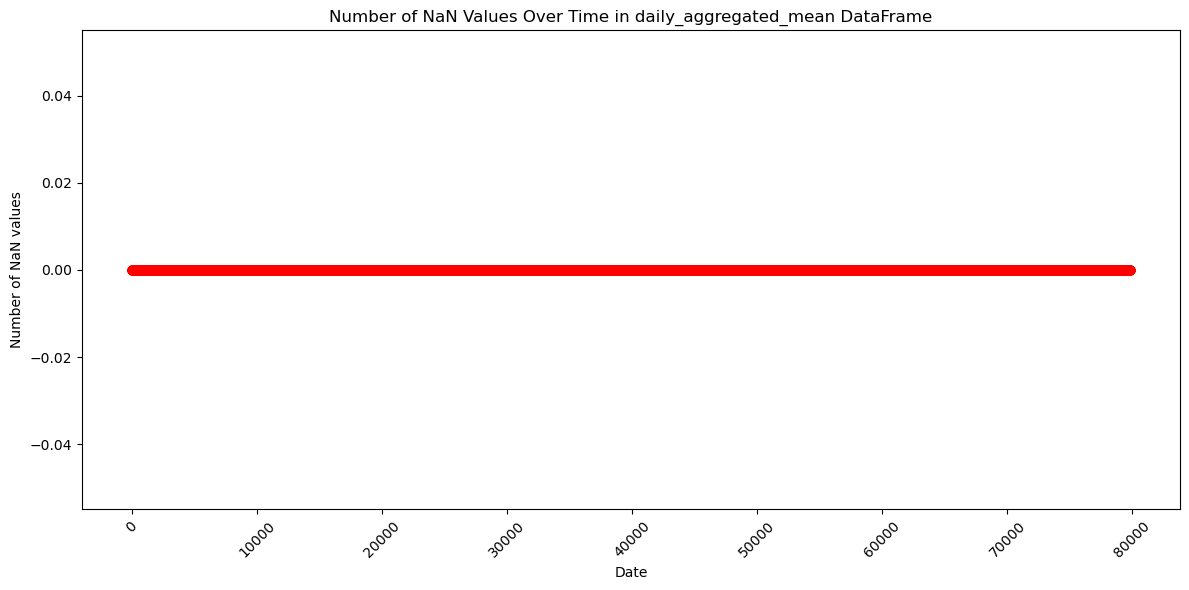

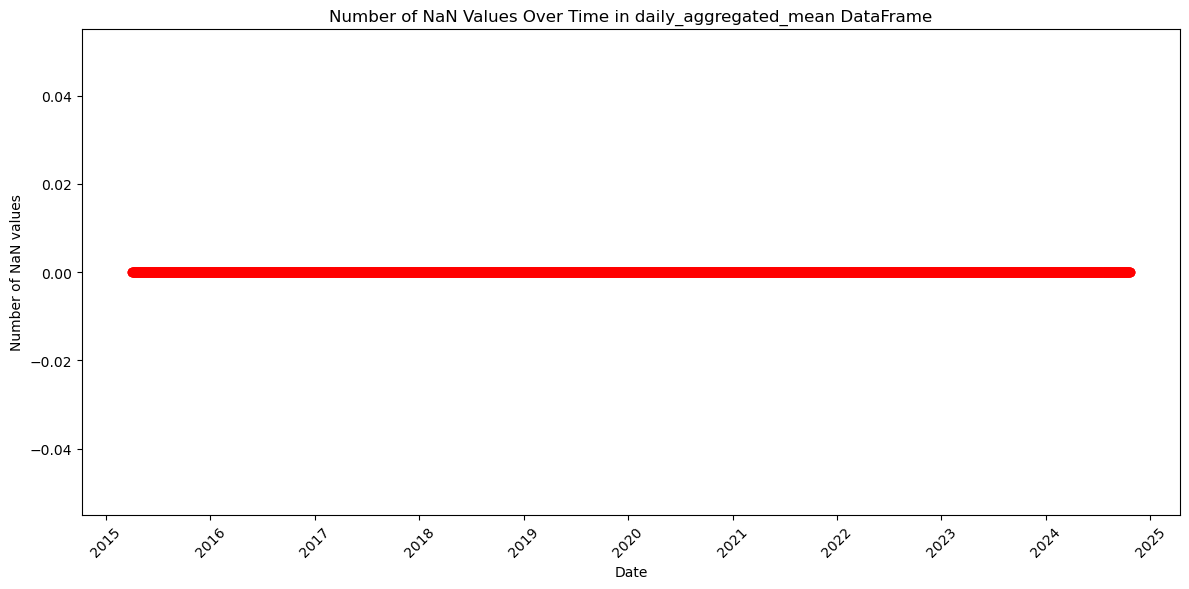

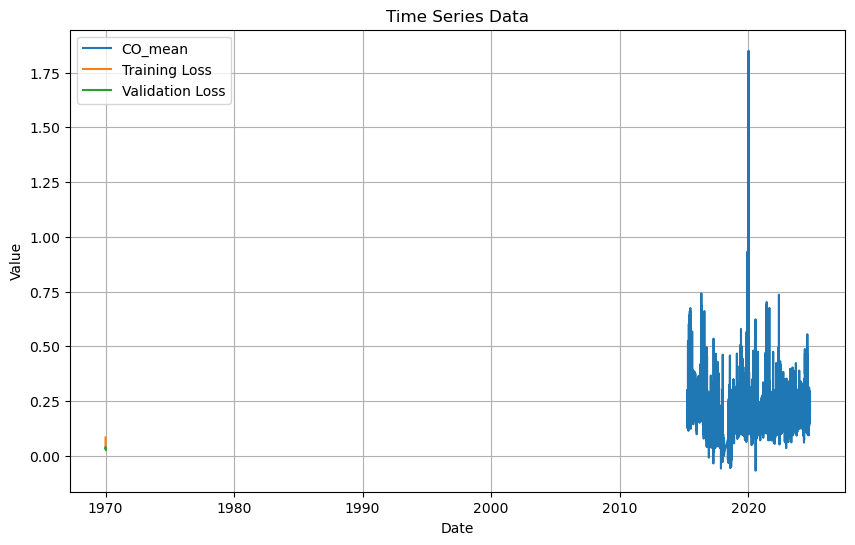

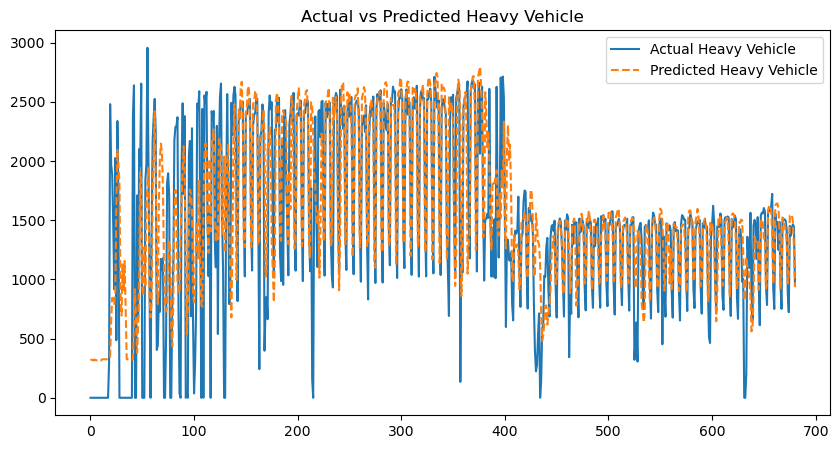

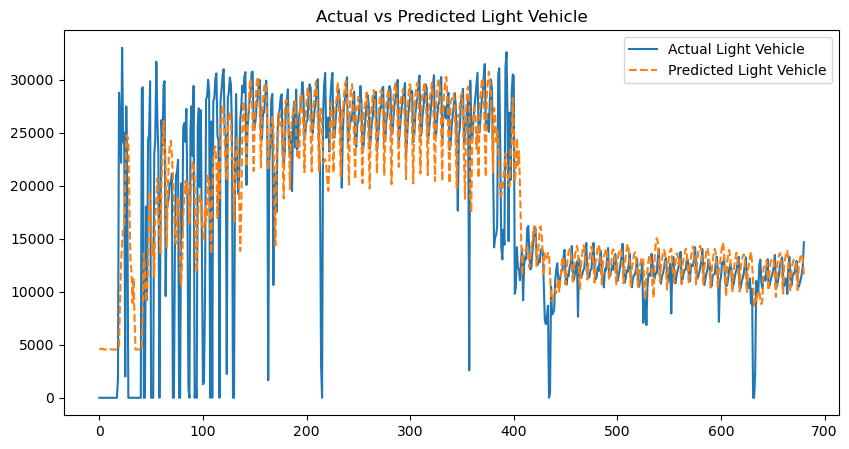

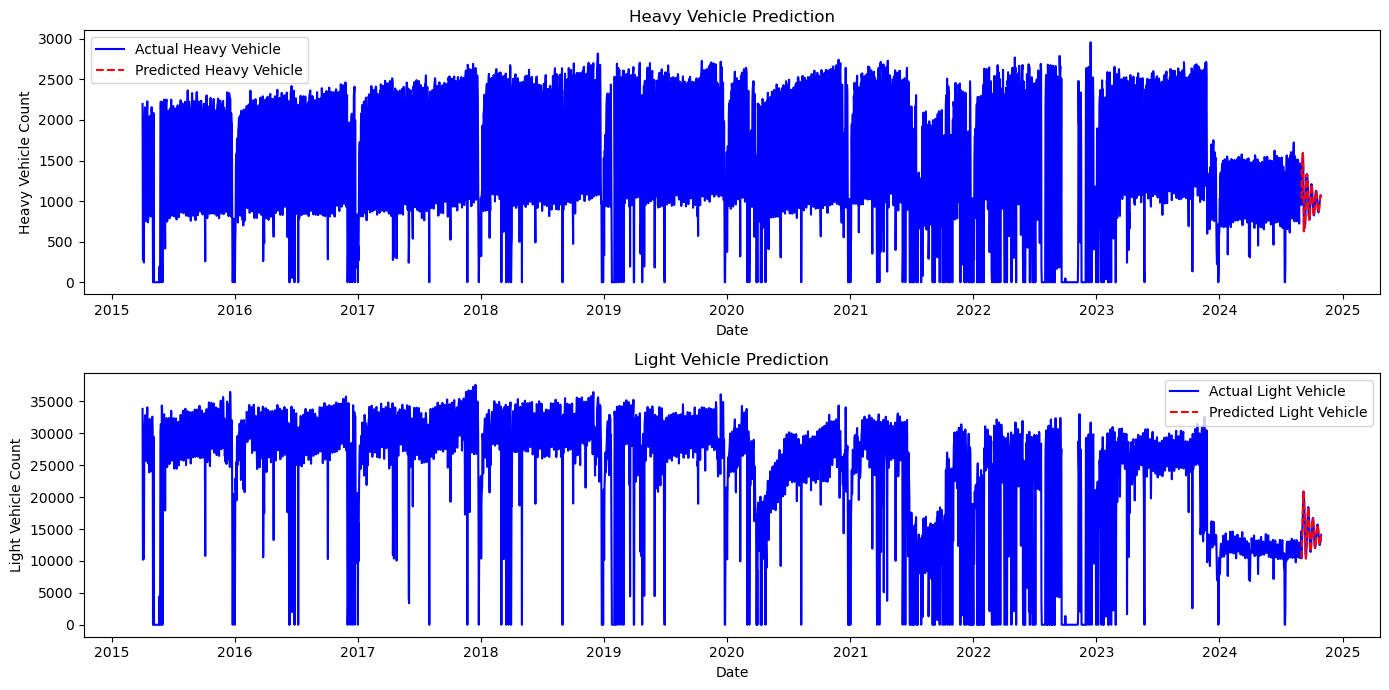

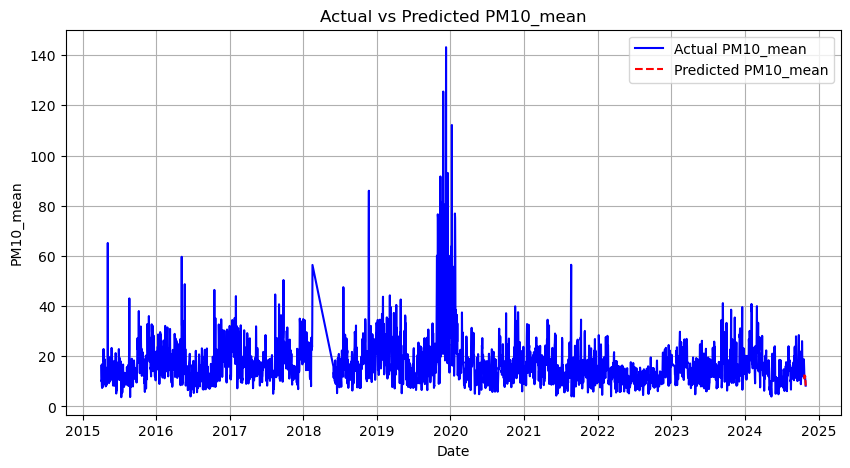

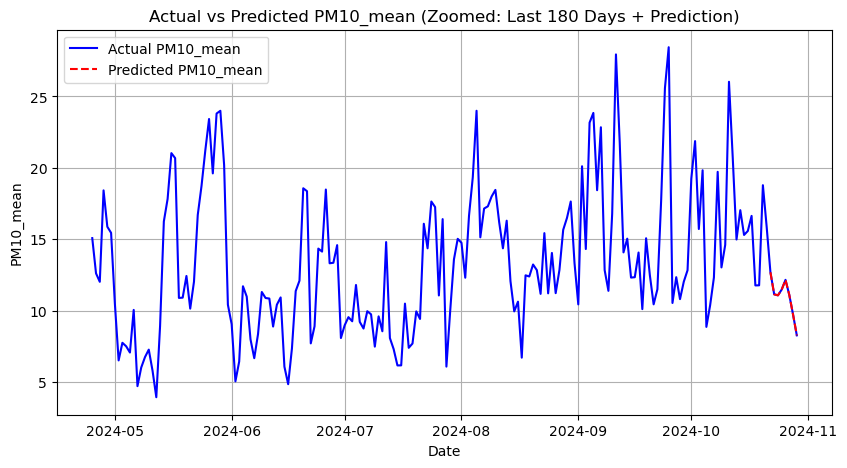

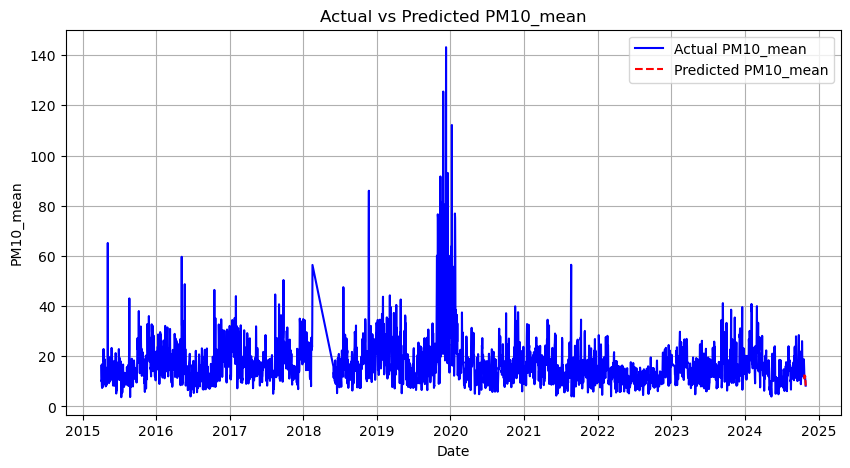

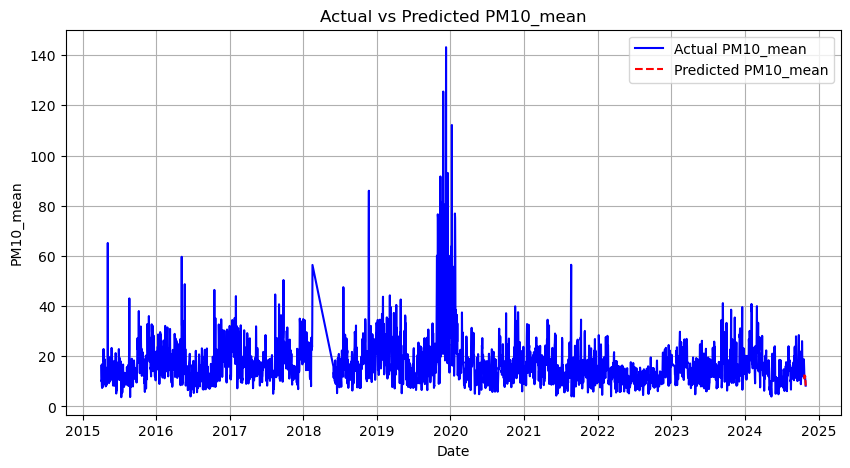

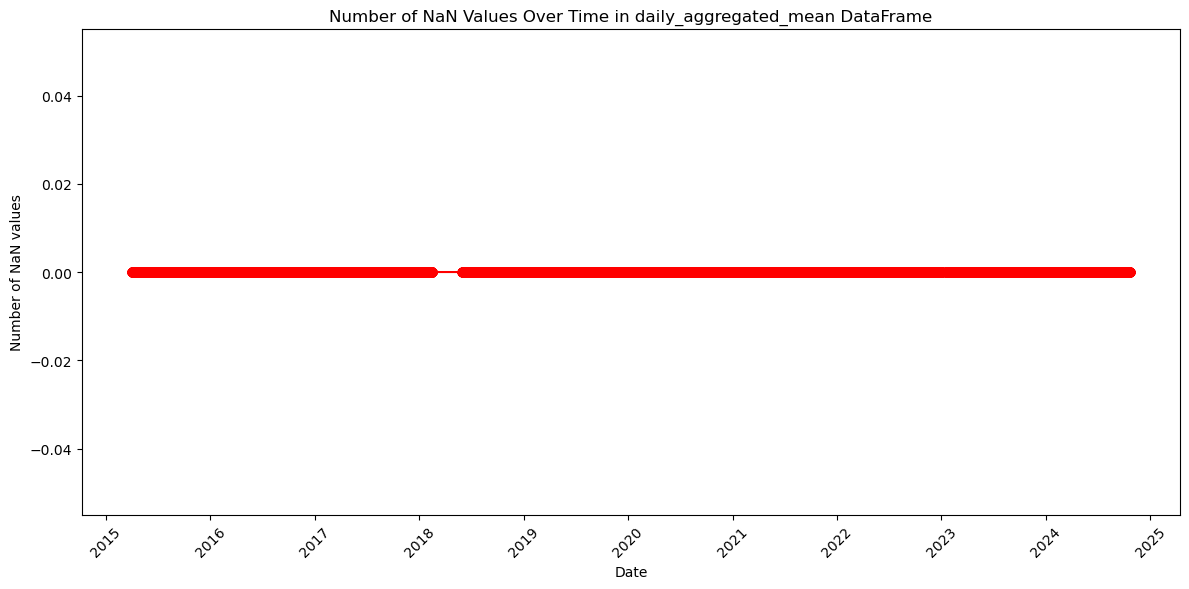

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline


# Plot the count of NaN values by time (i.e., how many NaNs per day)
nan_by_time = df_wide.isna().sum(axis=1)

# Plot the NaN counts over time
plt.figure(figsize=(12, 6))
plt.plot(nan_by_time, color='red', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Number of NaN values')
plt.title('Number of NaN Values Over Time in daily_aggregated_mean DataFrame')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [14]:
df_wide['datetime'] = pd.to_datetime(df_wide['Date']) + pd.to_timedelta(df_wide['Hour'], unit='h')

# Set 'datetime' as the index
df_wide.set_index('datetime', inplace=True)
df_wide.head()

,Site_Id,Date,Hour,HourDescription,CO,HUMID,NEPH,NO,NO2,OZONE,PM10,PM2.5,RAIN,SD1,SO2,SOLAR,TEMP,WDR,WSP
datetime,,,,,,,,,,,,,,,,,,,
2015-04-01 01:00:00,39,2015-04-01,1,12 am - 1 am,0.754289,94.199,0.232,6.026604,1.959503,0.049300,13.925,7.381,0.4,108.103,0.096339,-13.130,17.708,10.815,0.130
2015-04-01 02:00:00,39,2015-04-01,2,1 am - 2 am,0.754289,94.513,0.196,6.026604,1.959503,0.049300,18.096,5.359,0.4,59.602,0.096339,-12.835,18.285,325.715,0.605
2015-04-01 03:00:00,39,2015-04-01,3,2 am - 3 am,0.430155,95.974,0.177,1.928971,1.746824,0.129325,3.914,2.542,0.4,77.922,0.041979,-11.332,17.876,270.408,0.260
2015-04-01 04:00:00,39,2015-04-01,4,3 am - 4 am,0.407481,96.580,0.218,2.555419,1.651218,0.056325,3.088,5.263,0.4,77.073,0.064485,-11.606,17.231,261.068,0.109
2015-04-01 05:00:00,39,2015-04-01,5,4 am - 5 am,0.369815,97.003,0.198,2.426823,1.576204,0.047325,16.753,9.678,0.4,95.759,0.057291,-11.636,17.277,23.419,0.084


In [15]:

# Define the aggregation rules for each parameter
aggregation_rules_mean = {
    'CO': 'mean',           # Daily mean for CO
    'HUMID': 'mean',        # Daily mean for Humidity
    'NEPH': 'mean',         # Daily mean for NEPH
    'NO': 'mean',           # Daily mean for NO
    'NO2': 'mean',          # Daily mean for NO2
    'OZONE': 'mean',        # Daily mean for Ozone
    'SO2': 'mean',          # Daily mean for SO2
    'PM10': 'mean',         # Daily mean for PM10
    'PM2.5': 'mean',        # Daily mean for PM2.5
    'RAIN': 'sum',          # Total rainfall for the day
    'TEMP': ['min', 'max'], # Min and Max for temperature
    'WSP': 'max',           # Max wind speed for the day
    'SD1': 'mean',          # Mean wind direction 1
    'WDR': 'mean',          # Mean wind direction (special handling can be added)
}

df_wide_filled = df_wide.fillna(method='ffill').fillna(method='bfill')


# Now resample the data into daily data based on the rules above
daily_aggregated_mean = df_wide.resample('D').agg(aggregation_rules_mean)

# Flatten the MultiIndex columns if needed
daily_aggregated_mean.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in daily_aggregated_mean.columns]

daily_aggregated_mean.interpolate(method='linear', inplace=True)

# For columns that require rolling averages (if needed, change window size accordingly)
# For example, for CO, we might want a 24-hour rolling average
#daily_aggregated['CO_rolling_avg'] = df['CO'].resample('D').mean().rolling(window=24).mean()

# Display the daily aggregated results
#import ace_tools as tools; tools.display_dataframe_to_user(name="Daily Aggregated Data", dataframe=daily_aggregated)


In [16]:
import matplotlib.pyplot as plt

# Plot the count of NaN values by time (i.e., how many NaNs per day)
nan_by_time = daily_aggregated_mean.isna().sum(axis=1)

# Plot the NaN counts over time
plt.figure(figsize=(12, 6))
plt.plot(nan_by_time, color='red', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Number of NaN values')
plt.title('Number of NaN Values Over Time in daily_aggregated_mean DataFrame')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


/var/folders/br/kn0p5yrn6d771z_m2v7qll780000gp/T/ipykernel_73596/1619163164.py:20: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [17]:
daily_aggregated_mean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3493 entries, 2015-04-01 to 2024-10-22
Freq: D
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CO_mean     3493 non-null   float64
 1   HUMID_mean  3493 non-null   float64
 2   NEPH_mean   3493 non-null   float64
 3   NO_mean     3493 non-null   float64
 4   NO2_mean    3493 non-null   float64
 5   OZONE_mean  3493 non-null   float64
 6   SO2_mean    3493 non-null   float64
 7   PM10_mean   3493 non-null   float64
 8   PM2.5_mean  3493 non-null   float64
 9   RAIN_sum    3493 non-null   float64
 10  TEMP_min    3493 non-null   float64
 11  TEMP_max    3493 non-null   float64
 12  WSP_max     3493 non-null   float64
 13  SD1_mean    3493 non-null   float64
 14  WDR_mean    3493 non-null   float64
dtypes: float64(15)
memory usage: 436.6 KB


In [18]:
aggregation_rules_max = {
    'CO': 'max',           # Daily max for CO
    'HUMID': 'max',        # Daily max for Humidity
    'NEPH': 'max',         # Daily max for NEPH
    'NO': 'max',           # Daily max for NO
    'NO2': 'max',          # Daily max for NO2
    'OZONE': 'max',        # Daily max for Ozone
    'SO2': 'max',          # Daily max for SO2
    'PM10': 'max',         # Daily max for PM10
    'PM2.5': 'max',        # Daily max for PM2.5
    'RAIN': 'sum',          # Total rainfall for the day
    'TEMP': ['min', 'max'], # Min and Max for temperature
    'WSP': 'max',           # Max wind speed for the day
    'SD1': 'mean',          # Mean wind direction 1
    'WDR': 'mean',          # Mean wind direction (special handling can be added)
}

# Resample the data into daily data based on the rules above
daily_aggregated_max = df_wide.resample('D').agg(aggregation_rules_max)

# Flatten the MultiIndex columns resulting from min/max aggregations
daily_aggregated_max.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in daily_aggregated_max.columns]
daily_aggregated_mean.interpolate(method='linear', inplace=True)


In [19]:
daily_aggregated_max.head()

,CO_max,HUMID_max,NEPH_max,NO_max,NO2_max,OZONE_max,SO2_max,PM10_max,PM2.5_max,RAIN_sum,TEMP_min,TEMP_max,WSP_max,SD1_mean,WDR_mean
datetime,,,,,,,,,,,,,,,
2015-04-01,0.754289,97.537,0.899,6.026604,2.222698,2.652025,0.314923,22.869,9.678,9.2,17.231,24.246,3.542,45.571000,151.538087
2015-04-02,0.551271,91.118,0.365,4.302611,3.694051,3.475725,1.668084,43.421,12.787,9.6,17.933,28.129,4.109,37.699458,207.560083
2015-04-03,0.241453,96.332,0.495,0.093866,0.910417,2.544125,0.290586,29.974,12.809,9.6,17.491,20.109,4.784,31.234500,185.386208
2015-04-04,0.266662,96.292,0.248,0.015641,1.143133,2.369700,0.031020,15.113,14.542,9.6,15.401,18.951,3.493,40.681625,155.968417
2015-04-05,0.380490,97.052,0.237,0.353037,1.911808,3.240400,0.271021,20.258,7.211,9.6,15.190,23.641,2.606,66.519583,214.499625


# Traffic

In [20]:

# Load the data
df = pd.read_csv('traffic_victoria_road.csv')

# Melt the DataFrame to convert the hour columns into rows
df_melted = pd.melt(df, 
                    id_vars=['year', 'date', 'cardinal_direction_seq', 'classification_seq', 'public_holiday', 'school_holiday'],
                    value_vars=[f'hour_{str(i).zfill(2)}' for i in range(24)],
                    var_name='hour', 
                    value_name='traffic_count')

# Clean up the 'hour' column (convert 'hour_00' to '00', 'hour_01' to '01', etc.)
df_melted['hour'] = df_melted['hour'].str.replace('hour_', '').astype(int)

# Pivot the DataFrame to separate 'Heavy Vehicles' and 'Light Vehicles' into their own columns
df_pivoted = df_melted.pivot_table(index=['year', 'date', 'hour', 'public_holiday', 'school_holiday'],
                                   columns='classification_seq', 
                                   values='traffic_count').reset_index()

# Rename the columns for clarity
df_pivoted.columns.name = None  # Remove the pivot table's automatic column grouping name
df_pivoted.rename(columns={'Heavy Vehicles': 'heavy_vehicle', 'Light Vehicles': 'light_vehicle'}, inplace=True)

# Drop rows with missing values
df_clean = df_pivoted.dropna()

# Combine 'date' and 'hour' columns into a single 'datetime' column
df_clean.loc[:, 'datetime'] = pd.to_datetime(df_clean['date']) + pd.to_timedelta(df_clean['hour'], unit='h')

# Set 'datetime' as the index
df_clean = df_clean.set_index('datetime')

# Resample the data to daily frequency
daily_traffic_data = df_clean.resample('D').agg({
    'public_holiday': 'max',  # Taking the maximum value for the day
    'school_holiday': 'max',  # Taking the maximum value for the day
    'heavy_vehicle': 'sum',   # Summing heavy vehicle counts
    'light_vehicle': 'sum'    # Summing light vehicle counts
})


# Create a list of school term date ranges for 2020 to 2025
school_term_dates = [
    # 2020 Term dates (Eastern and Western division)
    ('2020-01-28', '2020-04-09'),  # Term 1 Eastern
    ('2020-02-04', '2020-04-09'),  # Term 1 Western
    ('2020-04-27', '2020-07-03'),  # Term 2
    ('2020-07-20', '2020-09-25'),  # Term 3
    ('2020-10-12', '2020-12-18'),  # Term 4
    # 2021 Term dates
    ('2021-01-27', '2021-04-01'),  # Term 1 Eastern
    ('2021-02-03', '2021-04-01'),  # Term 1 Western
    ('2021-04-19', '2021-06-25'),  # Term 2
    ('2021-07-12', '2021-09-17'),  # Term 3
    ('2021-10-05', '2021-12-17'),  # Term 4
    # 2022 Term dates
    ('2022-01-28', '2022-04-08'),  # Term 1 Eastern
    ('2022-02-04', '2022-04-08'),  # Term 1 Western
    ('2022-04-26', '2022-07-01'),  # Term 2
    ('2022-07-18', '2022-09-23'),  # Term 3
    ('2022-10-10', '2022-12-20'),  # Term 4
    # 2023 Term dates
    ('2023-01-27', '2023-04-06'),  # Term 1 Eastern
    ('2023-02-03', '2023-04-06'),  # Term 1 Western
    ('2023-04-24', '2023-06-30'),  # Term 2
    ('2023-07-17', '2023-09-22'),  # Term 3
    ('2023-10-09', '2023-12-19'),  # Term 4
    # 2024 Term dates
    ('2024-02-01', '2024-04-12'),  # Term 1 Eastern
    ('2024-02-08', '2024-04-12'),  # Term 1 Western
    ('2024-04-30', '2024-07-05'),  # Term 2
    ('2024-07-23', '2024-09-27'),  # Term 3
    ('2024-10-14', '2024-12-18'),  # Term 4
    # 2025 Term dates
    ('2025-02-04', '2025-04-11'),  # Term 1 Eastern
    ('2025-02-11', '2025-04-11'),  # Term 1 Western
    ('2025-04-30', '2025-07-04'),  # Term 2
    ('2025-07-22', '2025-09-26'),  # Term 3
    ('2025-10-13', '2025-12-19')   # Term 4
]

# Create a DataFrame for school term dates with 0 as school days
df_school_term = pd.DataFrame({
    'Start': pd.to_datetime([start for start, end in school_term_dates]),
    'End': pd.to_datetime([end for start, end in school_term_dates]),
    'school_holiday': 0  # School days are 0
})

# Create a date range DataFrame from 2020 to 2025
date_range = pd.date_range(start='2020-01-01', end='2025-12-31', freq='D')
df_dates = pd.DataFrame(date_range, columns=['datetime'])
df_dates['school_holiday'] = 1  # Default to 1 (holidays)

# Mark the term dates (non-holidays) as 0
for _, row in df_school_term.iterrows():
    df_dates.loc[(df_dates['datetime'] >= row['Start']) & (df_dates['datetime'] <= row['End']), 'school_holiday'] = 0

# Data for public holidays from 2020 to 2025
public_holidays = {
    'holiday': [
        "New Year's Day", "Australia Day", "Good Friday", "Easter Saturday", "Easter Sunday", 
        "Easter Monday", "Anzac Day", "King's Birthday", "Labour Day", "Christmas Day", "Boxing Day"
    ],
    '2020': [
        '2020-01-01', '2020-01-27', '2020-04-10', '2020-04-11', '2020-04-12', 
        '2020-04-13', '2020-04-25', '2020-06-08', '2020-10-05', '2020-12-25', '2020-12-26'
    ],
    '2021': [
        '2021-01-01', '2021-01-26', '2021-04-02', '2021-04-03', '2021-04-04', 
        '2021-04-05', '2021-04-25', '2021-06-14', '2021-10-04', '2021-12-25', '2021-12-26'
    ],
    '2022': [
        '2022-01-01', '2022-01-26', '2022-04-15', '2022-04-16', '2022-04-17', 
        '2022-04-18', '2022-04-25', '2022-06-13', '2022-10-03', '2022-12-25', '2022-12-26'
    ],
    '2023': [
        '2023-01-01', '2023-01-26', '2023-04-07', '2023-04-08', '2023-04-09', 
        '2023-04-10', '2023-04-25', '2023-06-12', '2023-10-02', '2023-12-25', '2023-12-26'
    ],
    '2024': [
        '2024-01-01', '2024-01-26', '2024-03-29', '2024-03-30', '2024-03-31', 
        '2024-04-01', '2024-04-25', '2024-06-10', '2024-10-07', '2024-12-25', '2024-12-26'
    ],
    '2025': [
        '2025-01-01', '2025-01-27', '2025-04-18', '2025-04-19', '2025-04-20', 
        '2025-04-21', '2025-04-25', '2025-06-09', '2025-10-06', '2025-12-25', '2025-12-26'
    ]
}

# Convert public holiday data to a DataFrame
df_holidays = pd.DataFrame(public_holidays)
df_holidays_melted = df_holidays.melt(id_vars=['holiday'], var_name='Year', value_name='Date')
df_holidays_melted = df_holidays_melted.dropna()
df_holidays_melted['Date'] = pd.to_datetime(df_holidays_melted['Date'])
df_holidays_melted['public_holiday'] = 1

# Merge public holidays into the date range DataFrame
df_final = pd.merge(df_dates, df_holidays_melted[['Date', 'public_holiday']], left_on='datetime', right_on='Date', how='left')
df_final['public_holiday'] = df_final['public_holiday'].fillna(0).astype(int)

# Drop unnecessary 'Date' column
df_holiday = df_final.drop(columns=['Date'])


# Get the first date in df_holiday
first_date = df_holiday.index.min()

df_holiday.set_index('datetime', inplace=True)
#daily_traffic_data.set_index('datetime', inplace=True)


# Combine both DataFrames to include all rows from df_holiday that are not present in daily_traffic_data
# This will ensure that missing dates are added
daily_traffic_data = daily_traffic_data.combine_first(df_holiday)

# Update the 'school_holiday' and 'public_holiday' columns with values from df_holiday
daily_traffic_data.update(df_holiday[['school_holiday', 'public_holiday']])


# Using 'outer' join to ensure we keep all dates across the three DataFrames
combined_data = pd.concat([daily_aggregated_mean, daily_traffic_data], axis=1, join='outer')

# Drop the first row of the DataFrame
combined_data = combined_data.iloc[1:]

# Find the last entry (non-NaN) for 'heavy_vehicle'
last_entry_date = combined_data['heavy_vehicle'].last_valid_index()

# Forward fill NaN values for all columns between the second row and the last valid entry for 'heavy_vehicle'
combined_data.loc[:last_entry_date] = combined_data.loc[:last_entry_date].fillna(method='ffill')


/var/folders/br/kn0p5yrn6d771z_m2v7qll780000gp/T/ipykernel_73596/451319404.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'datetime'] = pd.to_datetime(df_clean['date']) + pd.to_timedelta(df_clean['hour'], unit='h')


In [21]:
# Using 'outer' join to ensure we keep all dates across the three DataFrames
combined_data = pd.concat([daily_aggregated_mean, daily_traffic_data], axis=1, join='outer')

# Drop the first row of the DataFrame
combined_data = combined_data.iloc[1:]

# Find the last entry (non-NaN) for 'heavy_vehicle'
last_entry_date = combined_data['heavy_vehicle'].last_valid_index()

# Forward fill NaN values for all columns between the second row and the last valid entry for 'heavy_vehicle'
combined_data.loc[:last_entry_date] = combined_data.loc[:last_entry_date].fillna(method='ffill')


# Weather Forecast

In [22]:
from ftplib import FTP
import xml.etree.ElementTree as ET
import pandas as pd
import re

# Connect to FTP and download the XML file
ftp = FTP('ftp.bom.gov.au')
ftp.login()
ftp.cwd('/anon/gen/fwo/')
with open('IDN11060.xml', 'wb') as file:
    ftp.retrbinary('RETR IDN11060.xml', file.write)
ftp.quit()

# Parse the XML file
tree = ET.parse('IDN11060.xml')
root = tree.getroot()

# Prepare an empty list to store the data
data = []

# Loop through each 'area' element to get all forecast data
for area in root.findall('.//area'):
    location = area.attrib.get('description')
    
    # Loop through each forecast period in the location
    for period in area.findall('.//forecast-period'):
        start_time = period.attrib.get('start-time-local')
        
        # Initialize a dictionary to hold the data for this forecast period
        forecast_data = {
            'Location': location,
            'Date': start_time
        }
        
        # Loop through all 'element' tags
        for element in period.findall('element'):
            param_type = element.attrib.get('type')
            value = element.text
            units = element.attrib.get('units', '')
            forecast_data[f'{param_type} ({units})'] = value
        
        # Loop through all 'text' tags
        for text in period.findall('text'):
            text_type = text.attrib.get('type')
            text_value = text.text
            forecast_data[text_type] = text_value
        
        # Append the forecast data to the list
        data.append(forecast_data)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

df = df[['Location', 'Date', 
             'air_temperature_maximum (Celsius)', 'air_temperature_minimum (Celsius)', 
             'precipitation_range ()']].copy()

# Renaming the columns to the desired format
df.columns = ['Location', 'Date', 'Temp_Max', 'Temp_Min', 'Rain']

def extract_rain_value(rain):
    if pd.isnull(rain):
        return 0  # If NaN, return 0
    # Extract the larger number from strings like "0 to 2 mm"
    rain_values = re.findall(r'\d+', rain)
    if rain_values:
        return int(rain_values[-1])  # Return the largest number (last in the list)
    return 0  # Default to 0 if no numbers are found

# Apply the extraction function to the 'Rain' column
df['Rain'] = df['Rain'].apply(extract_rain_value)


df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

# Convert 'Temp_Max' and 'Temp_Min' columns to numeric, forcing errors to NaN if conversion fails
df['Temp_Max'] = pd.to_numeric(df['Temp_Max'], errors='coerce')
df['Temp_Min'] = pd.to_numeric(df['Temp_Min'], errors='coerce')

# Calculating the difference between Temp_Max and Temp_Min for each row
df['Temp_Diff'] = df['Temp_Max'] - df['Temp_Min']

# Calculating the average difference between Temp_Max and Temp_Min (excluding NaN values)
avg_temp_diff = df['Temp_Diff'].mean()

# Filling the NaN values in Temp_Min by subtracting the average temperature difference from Temp_Max
df['Temp_Min'].fillna(df['Temp_Max'] - avg_temp_diff, inplace=True)

# Dropping the Temp_Diff column as it's no longer needed
df.drop(columns=['Temp_Diff'], inplace=True)

df_sydney = df[df['Location'] == 'Sydney'].copy()
# Connect to FTP and download the XML file
ftp = FTP('ftp.bom.gov.au')
ftp.login()
ftp.cwd('/anon/gen/fwo/')
with open('IDN11050.xml', 'wb') as file:
    ftp.retrbinary('RETR IDN11050.xml', file.write)
ftp.quit()

# Parse the XML file
tree = ET.parse('IDN11050.xml')
root = tree.getroot()

# Prepare an empty list to store the data
data = []

# Loop through each 'area' element to get all forecast data
for area in root.findall('.//area'):
    location = area.attrib.get('description')
    
    # Loop through each forecast period in the location
    for period in area.findall('.//forecast-period'):
        start_time = period.attrib.get('start-time-local')
        
        # Initialize a dictionary to hold the data for this forecast period
        forecast_data = {
            'Location': location,
            'Date': start_time
        }
        
        # Loop through all 'element' tags
        for element in period.findall('element'):
            param_type = element.attrib.get('type')
            value = element.text
            units = element.attrib.get('units', '')
            forecast_data[f'{param_type} ({units})'] = value
        
        # Loop through all 'text' tags
        for text in period.findall('text'):
            text_type = text.attrib.get('type')
            text_value = text.text
            forecast_data[text_type] = text_value
        
        # Append the forecast data to the list
        data.append(forecast_data)

# Create a DataFrame from the list of dictionaries
df_wind = pd.DataFrame(data)


# Mapping wind direction text to degrees
wind_direction_degrees = {
    'northerly': 0, 'north to northeasterly': 22.5, 'northeasterly': 45, 'east to northeasterly': 67.5,
    'easterly': 90, 'east to southeasterly': 112.5, 'southeast': 135, 'south to southeast': 157.5,
    'southerly': 180, 'south to southwesterly': 202.5, 'southwesterly': 225, 'west-southwesterly': 247.5,
    'westerly': 270, 'west to northwesterly': 292.5, 'northwesterly': 315, 'north to northwesterly': 337.5
}

# Function to extract wind speed and direction from the 'Forecast' column
def extract_wind_info(forecast):
    if pd.isnull(forecast):
        return None, None, None  # Handle None or NaN values
    
    
    # Regular expression to handle both "Winds ..." and "becoming ..."
    wind_info = re.search(r'(Winds|becoming)\s([a-zA-Z\s]+)\s(\d+)(?:\sto\s(\d+))?\skm/h', forecast)
    
    if wind_info:
        wind_direction = wind_info.group(2).strip().lower()
        wind_speed_min = int(wind_info.group(3))
        wind_speed_max = int(wind_info.group(4)) if wind_info.group(4) else None
        
        # Convert the wind direction to degrees if it's in the mapping
        for direction, degrees in wind_direction_degrees.items():
            if direction in wind_direction:
                wind_direction_degrees_value = degrees
                break
        else:
            wind_direction_degrees_value = None  # Handle unknown direction
        
        return wind_direction_degrees_value, wind_speed_min, wind_speed_max
    
    return None, None, None

# Apply the function to the 'Forecast' column and store the results in new columns
df_wind['Wind Direction (Degrees)'], df_wind['Wind Speed Min'], df_wind['Wind Speed Max'] = zip(*df_wind['forecast'].apply(extract_wind_info))

def kmh_to_ms(speed_kmh):
    return round(speed_kmh * 0.27778, 2) if speed_kmh is not None else None

# Apply the conversion after extracting the wind data
df_wind['Wind Speed Min (m/s)'] = df_wind['Wind Speed Min'].apply(kmh_to_ms)
df_wind['Wind Speed Max (m/s)'] = df_wind['Wind Speed Max'].apply(kmh_to_ms)
df_wind['Date'] = pd.to_datetime(df_wind['Date']).dt.strftime('%Y-%m-%d')

# Display the extracted wind information
df_wind=df_wind[['Location',
                 'Date','Wind Direction (Degrees)', 
                 'Wind Speed Min (m/s)', 
                 'Wind Speed Max (m/s)',
                 'forecast']]

df_wind_sydney = df_wind[df_wind['Location'] == 'Sydney'][['Date', 
                                                           'Wind Direction (Degrees)', 
                                                           'Wind Speed Min (m/s)', 
                                                           'Wind Speed Max (m/s)',
                                                           'forecast']].copy()

df_forecast_sydney = pd.merge(df_sydney, df_wind_sydney, on='Date', how='inner')

df_forecast_sydney = df_forecast_sydney.drop(columns=['Location'])  # Drop the "Location" column
df_forecast_sydney['Date'] = pd.to_datetime(df_forecast_sydney['Date'])  # Convert 'Date' column to datetime
df_forecast_sydney = df_forecast_sydney.set_index('Date')  # Set 'Date' as the index


df_forecast_sydney.rename(columns={
    'Rain': 'RAIN_sum',
    'Wind Direction (Degrees)': 'WDR_mean',
    'Wind Speed Max (m/s)': 'WSP_max',
    'Temp_Max': 'TEMP_max',
    'Temp_Min': 'TEMP_min',
    'forecast': 'Forecast'
}, inplace=True)

df_7forecast_sydney = df_forecast_sydney[['TEMP_max', 
                                          'TEMP_min', 
                                          'RAIN_sum', 
                                          'WSP_max', 
                                          'WDR_mean',
                                         'Forecast']]


In [23]:
df_7forecast_sydney.head()

,TEMP_max,TEMP_min,RAIN_sum,WSP_max,WDR_mean,forecast
Date,,,,,,
2024-10-22,NaN,NaN,0,NaN,NaN,Clear. Light winds.
2024-10-23,27.0,14.0,0,NaN,NaN,Mostly sunny morning. The chance of fog in the...
2024-10-24,23.0,17.0,9,5.56,202.5,"Partly cloudy. High chance of showers, most li..."
2024-10-25,21.0,13.0,2,5.56,180.0,Partly cloudy. Medium chance of showers. Winds...
2024-10-26,20.0,14.0,1,5.56,202.5,Partly cloudy. Slight chance of a shower in th...


# Combine Datasets

In [24]:
# Ensure both DataFrames have their indices in datetime format
combined_data.index = pd.to_datetime(combined_data.index)
df_7forecast_sydney.index = pd.to_datetime(df_7forecast_sydney.index)

# Remove any overlapping dates between the indices of combined_data and df_7forecast_sydney
combined_data = combined_data[~combined_data.index.isin(df_7forecast_sydney.index)]

# Combine df_7forecast_sydney into combined_data, updating existing columns
combined_data = pd.concat([combined_data, df_7forecast_sydney], axis=0, join='outer')

# Sort by index (date)
combined_data = combined_data.sort_index()

# Drop the first row of the DataFrame if needed
combined_data = combined_data.iloc[1:]

# Find the last entry (non-NaN) for 'heavy_vehicle'
last_entry_date = combined_data['heavy_vehicle'].last_valid_index()

# Forward fill NaN values for all columns between the second row and the last valid entry for 'heavy_vehicle'
combined_data.loc[:last_entry_date] = combined_data.loc[:last_entry_date].fillna(method='ffill')

# Display the final combined DataFrame to check the result


In [25]:
combined_data.loc['2024-10-15']

CO_mean            0.192535
HUMID_mean        75.038333
NEPH_mean          0.204792
NO_mean           -0.001461
NO2_mean           0.486783
OZONE_mean         2.190367
SO2_mean            0.01448
PM10_mean         15.299292
PM2.5_mean         4.935708
RAIN_sum                7.6
TEMP_min             13.933
TEMP_max             17.209
WSP_max               3.727
SD1_mean          40.247292
WDR_mean            183.219
heavy_vehicle           NaN
light_vehicle           NaN
public_holiday          0.0
school_holiday          0.0
forecast                NaN
Name: 2024-10-15 00:00:00, dtype: object

In [26]:
import matplotlib.pyplot as plt

def plot_columns(df, columns):
    plt.figure(figsize=(10, 6))
    for column in columns:
        if column in df.columns:
            plt.plot(df.index, df[column], label=column)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Data')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage: Plot multiple columns
plot_columns(combined_data, ['CO_mean'])

/var/folders/br/kn0p5yrn6d771z_m2v7qll780000gp/T/ipykernel_73596/1223993972.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


# Traffic Model

Epoch 1/10


/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


88/88 [==============================] - 4s 46ms/step - loss: 0.0791 - val_loss: 0.0352
Epoch 2/10
88/88 [==============================] - 2s 25ms/step - loss: 0.0523 - val_loss: 0.0321
Epoch 3/10
88/88 [==============================] - 2s 22ms/step - loss: 0.0509 - val_loss: 0.0295
Epoch 4/10
88/88 [==============================] - 2s 23ms/step - loss: 0.0488 - val_loss: 0.0287
Epoch 5/10
88/88 [==============================] - 2s 22ms/step - loss: 0.0452 - val_loss: 0.0256
Epoch 6/10
88/88 [==============================] - 2s 23ms/step - loss: 0.0409 - val_loss: 0.0253
Epoch 7/10
88/88 [==============================] - 2s 25ms/step - loss: 0.0383 - val_loss: 0.0227
Epoch 8/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0370 - val_loss: 0.0235
Epoch 9/10
88/88 [==============================] - 2s 23ms/step - loss: 0.0371 - val_loss: 0.0226
Epoch 10/10
22/22 [==============================] - 0s 9ms/step
RMSE (Heavy Vehicle): 472.6507183369337
RMSE (Light Veh

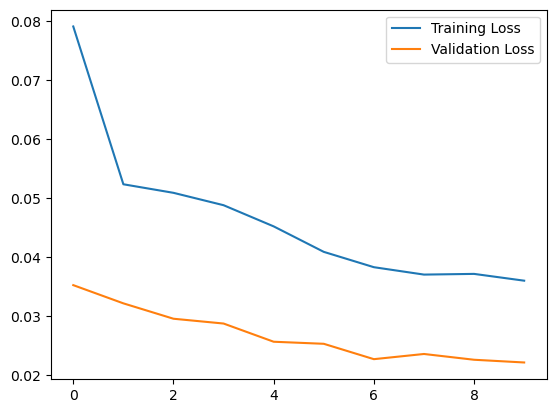

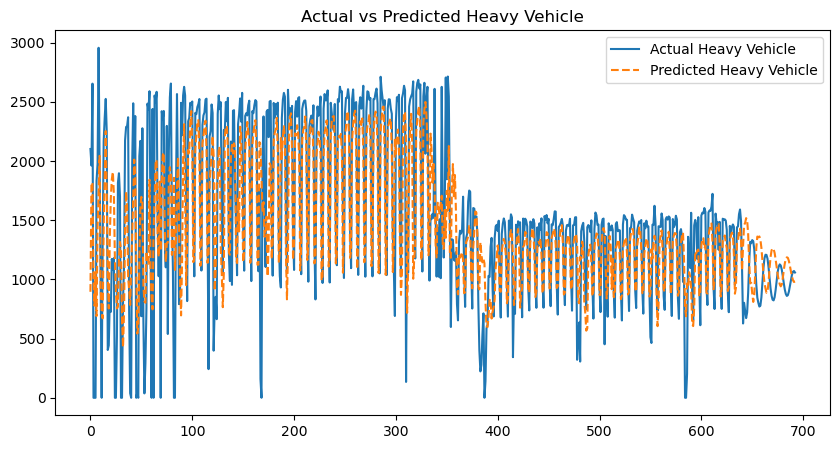

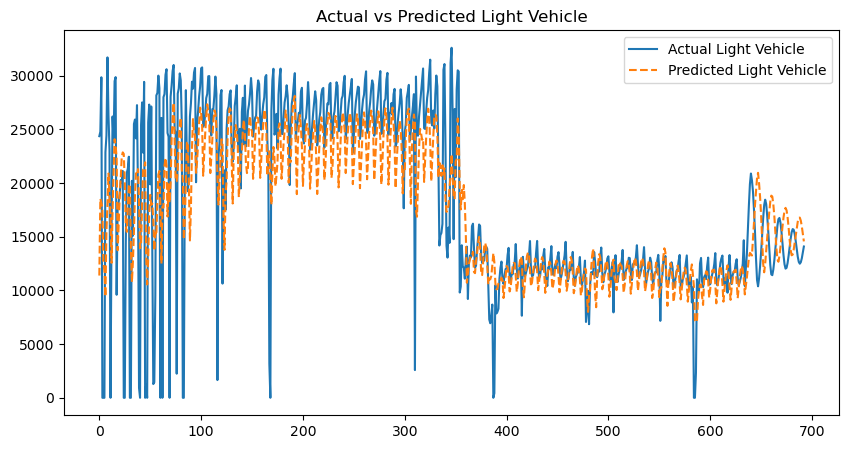

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# Prepare the data
features = ['heavy_vehicle', 'light_vehicle', 'RAIN_sum']

scaler_full = MinMaxScaler()
scaled_data = scaler_full.fit_transform(combined_data[features])  # Scale selected columns

# Create a new DataFrame with the scaled data and the same index
combined_data_scaled = pd.DataFrame(scaled_data, columns=features, index=combined_data.index)

# Handle missing values
first_missing_index = combined_data[['heavy_vehicle', 'light_vehicle']].isnull().idxmax().max()
first_missing_loc = combined_data.index.get_loc(first_missing_index)
combined_data_filtered = combined_data_scaled.iloc[:first_missing_loc]

# Create sequences (LSTM expects a 3D input: [samples, timesteps, features])
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, :2])  # Target for heavy_vehicle (0) and light_vehicle (1)
    return np.array(X), np.array(y)

sequence_length = 7
data = combined_data_filtered.values
X, y = create_sequences(data, sequence_length)

# Split the data into training and testing data
split_index = int(len(combined_data_filtered) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, len(features))))
model.add(LSTM(64))
model.add(Dense(2))  # Predict two values at a time (for heavy_vehicle and light_vehicle)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predict on the test data
y_pred = model.predict(X_test)

# Create a separate scaler only for 'heavy_vehicle' and 'light_vehicle'
scaler_vehicle = MinMaxScaler()
scaler_vehicle.fit(combined_data[['heavy_vehicle', 'light_vehicle']])

# Inverse transform the predictions and actual values for heavy_vehicle and light_vehicle
y_pred_inverse = scaler_vehicle.inverse_transform(y_pred)
y_test_inverse = scaler_vehicle.inverse_transform(y_test)

# Calculate RMSE and MAE
rmse_heavy_vehicle = np.sqrt(mean_squared_error(y_test_inverse[:, 0], y_pred_inverse[:, 0]))
rmse_light_vehicle = np.sqrt(mean_squared_error(y_test_inverse[:, 1], y_pred_inverse[:, 1]))
mae_heavy_vehicle = mean_absolute_error(y_test_inverse[:, 0], y_pred_inverse[:, 0])
mae_light_vehicle = mean_absolute_error(y_test_inverse[:, 1], y_pred_inverse[:, 1])

print(f"RMSE (Heavy Vehicle): {rmse_heavy_vehicle}")
print(f"RMSE (Light Vehicle): {rmse_light_vehicle}")
print(f"MAE (Heavy Vehicle): {mae_heavy_vehicle}")
print(f"MAE (Light Vehicle): {mae_light_vehicle}")

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot actual vs predicted values for heavy_vehicle and light_vehicle
plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:, 0], label='Actual Heavy Vehicle')
plt.plot(y_pred_inverse[:, 0], label='Predicted Heavy Vehicle', linestyle='--')
plt.title('Actual vs Predicted Heavy Vehicle')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:, 1], label='Actual Light Vehicle')
plt.plot(y_pred_inverse[:, 1], label='Predicted Light Vehicle', linestyle='--')
plt.title('Actual vs Predicted Light Vehicle')
plt.legend()
plt.show()


In [56]:

print(f"RMSE (Heavy Vehicle): {rmse_heavy_vehicle}")
print(f"RMSE (Light Vehicle): {rmse_light_vehicle}")

print(f"MAE (Heavy Vehicle): {mae_heavy_vehicle}")
print(f"MAE (Light Vehicle): {mae_light_vehicle}")

RMSE (Heavy Vehicle): 476.16565863992577
RMSE (Light Vehicle): 5864.521594486382
MAE (Heavy Vehicle): 316.9861332176396
MAE (Light Vehicle): 4239.489519920184


In [50]:

print(f"RMSE (Heavy Vehicle): {rmse_heavy_vehicle}")
print(f"RMSE (Light Vehicle): {rmse_light_vehicle}")

print(f"MAE (Heavy Vehicle): {mae_heavy_vehicle}")
print(f"MAE (Light Vehicle): {mae_light_vehicle}")

RMSE (Heavy Vehicle): 515.9587848013232
RMSE (Light Vehicle): 5739.531788536851
MAE (Heavy Vehicle): 332.2483031599182
MAE (Light Vehicle): 3728.2673974394274


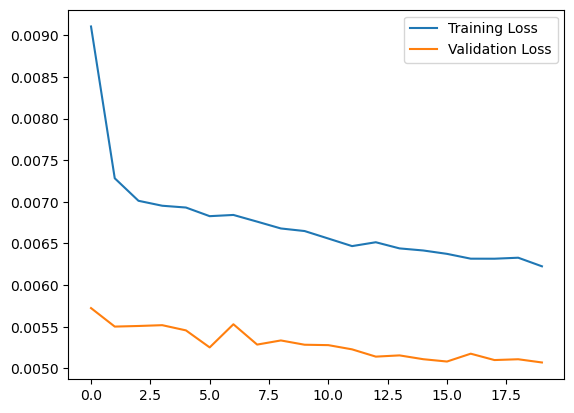

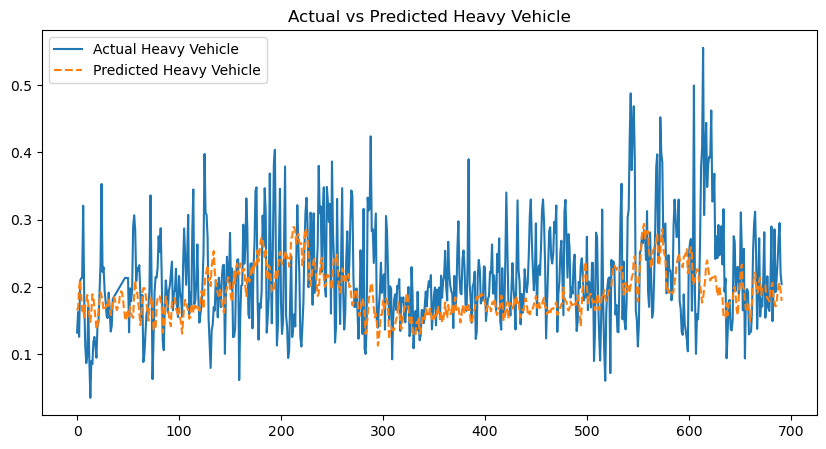

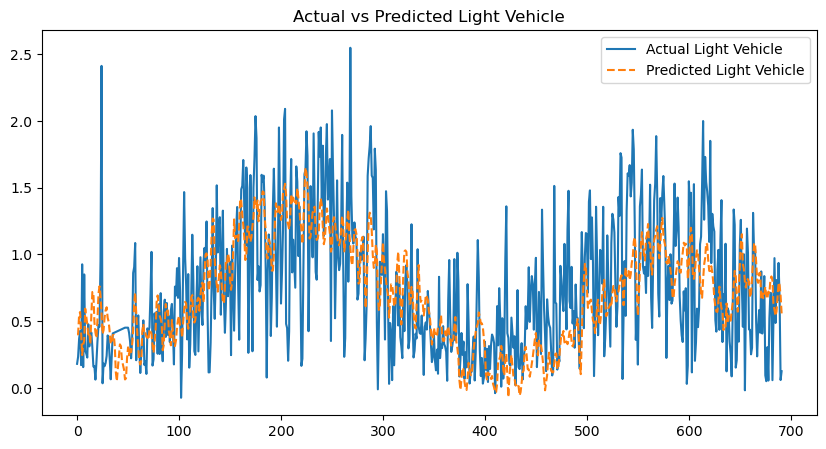

In [51]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# plot actual vs predicted values for heavy_vehicle and light_vehicle
plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:, 0], label='Actual Heavy Vehicle')
plt.plot(y_pred_inverse[:, 0], label='Predicted Heavy Vehicle', linestyle='--')
plt.title('Actual vs Predicted Heavy Vehicle')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:, 1], label='Actual Light Vehicle')
plt.plot(y_pred_inverse[:, 1], label='Predicted Light Vehicle', linestyle='--')
plt.title('Actual vs Predicted Light Vehicle')
plt.legend()
plt.show()

# Traffic Prediction

In [28]:
import numpy as np
import pandas as pd

# Step 1: Prepare to make rolling predictions from the first missing value until 8 days from today
today = pd.Timestamp.today()
days_to_predict = (today - first_missing_index).days + 8  # From first missing value to 8 days from today

# Step 2: Prepare the last valid sequence for prediction
# Assume the model was trained on a sequence of 7 days and all features were used in training
last_sequence = combined_data_scaled.iloc[first_missing_loc-sequence_length:first_missing_loc].values
pred_input = np.array([last_sequence])

# Step 3: Predict for all missing days and 8 days into the future (Rolling Forecast)
predictions_future = []
for _ in range(days_to_predict):
    # Predict one step ahead
    pred = model.predict(pred_input)
    predictions_future.append(pred[0])  # Store the prediction for the current step
    
    # Update pred_input by appending the prediction and removing the first timestep
    pred_input = np.append(pred_input[:, 1:, :], [[np.hstack([pred_input[0, -1, 2:], pred[0]])]], axis=1)

# Step 4: Inverse transform the predictions ONLY for heavy_vehicle and light_vehicle
# Assuming the scaler was originally fitted only on 'heavy_vehicle' and 'light_vehicle' columns
predictions_future = np.array(predictions_future)

# Perform the inverse transform only on the 2 columns (heavy_vehicle, light_vehicle)
scaler_vehicle = MinMaxScaler()
scaler_vehicle.fit(combined_data[['heavy_vehicle', 'light_vehicle']])  # Fit the scaler only on relevant columns
predictions_future_scaled = scaler_vehicle.inverse_transform(predictions_future[:, :2])  # Inverse-transform only the 2 columns

# Step 5: Create a DataFrame of the predicted values
predicted_dates = pd.date_range(start=first_missing_index, periods=days_to_predict)
predicted_values_df = pd.DataFrame(predictions_future_scaled, columns=['heavy_vehicle', 'light_vehicle'], index=predicted_dates)

# Step 6: Update the original combined_data DataFrame with the predictions
combined_data.update(predicted_values_df)

# Display the updated DataFrame
print(combined_data.loc[first_missing_index:])


1/1 [==============================] - 0s 18ms/step


/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 17ms/step
             CO_mean  HUMID_mean  NEPH_mean   NO_mean  NO2_mean  OZONE_mean  \
2024-09-01  0.137270   31.843417   0.058875 -0.001673  0.256140    3.054250   
2024-09-02  0.135443   29.808250   0.079292 -0.028163  0.086860    3.188738   
2024-09-03  0.151750   42.383500   0.083542  0.063050  0.559288    2.637529   
2024-09-04  0.275515   61.051917   0.279458  0.861777  1.337082    1.789696   
2024-09-05  0.267276   48.832208   0.256958  0.768037  1.220985    2.048054   
...              ...         ...        ...       ...       ...         ...   
2025-12-27       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-28       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-29       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-30       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-31       NaN         NaN        NaN       NaN       NaN         NaN   


KeyError: 'heavy_vehicle'

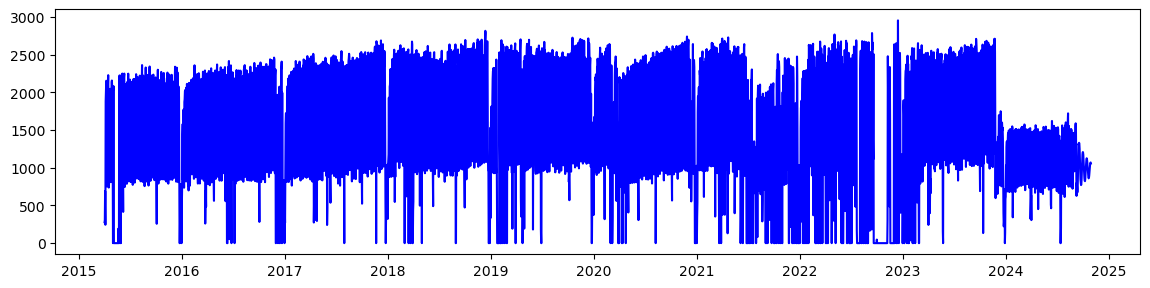

In [52]:
# Step 7: Plot the actual and predicted values for heavy_vehicle and light_vehicle
plt.figure(figsize=(14, 7))

# Plot for heavy_vehicle
plt.subplot(2, 1, 1)
plt.plot(combined_data.index, combined_data['heavy_vehicle'], label='Actual Heavy Vehicle', color='blue')
plt.plot(predicted_values_df.index, predicted_values_df['heavy_vehicle'], label='Predicted Heavy Vehicle', color='red', linestyle='--')
plt.title('Heavy Vehicle Prediction')
plt.xlabel('Date')
plt.ylabel('Heavy Vehicle Count')
plt.legend()

# Plot for light_vehicle
plt.subplot(2, 1, 2)
plt.plot(combined_data.index, combined_data['light_vehicle'], label='Actual Light Vehicle', color='blue')
plt.plot(predicted_values_df.index, predicted_values_df['light_vehicle'], label='Predicted Light Vehicle', color='red', linestyle='--')
plt.title('Light Vehicle Prediction')
plt.xlabel('Date')
plt.ylabel('Light Vehicle Count')
plt.legend()

plt.tight_layout()
plt.show()

# Air Quality Model

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# Step 1: Prepare the data
features = ['TEMP_min', 'TEMP_max', 'RAIN_sum', 'WDR_mean', 'WSP_max', 'heavy_vehicle', 'light_vehicle']
target = ['CO_mean', 'NO2_mean', 'NO_mean', 'OZONE_mean', 'PM10_mean', 'PM2.5_mean', 'SO2_mean']

# Scale the features and target variables
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(combined_data[features])

scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(combined_data[target])

# Combine the scaled features and targets into a single DataFrame
combined_data_scaled = pd.DataFrame(np.hstack([scaled_features, scaled_target]), 
                                    columns=features + target, 
                                    index=combined_data.index)

# Handle missing values
first_missing_index = combined_data[target].isnull().idxmax().max()
first_missing_loc = combined_data.index.get_loc(first_missing_index)

# Filter data up to the first missing value
combined_data_filtered = combined_data_scaled.iloc[:first_missing_loc]

# Create sequences (LSTM expects a 3D input: [samples, timesteps, features])
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :len(features)])  # Input sequence (features)
        y.append(data[i, len(features):])              # Target sequence (CO, NO2, etc.)
    return np.array(X), np.array(y)

# Define the sequence length (7-day sequences)
sequence_length = 7
data = combined_data_filtered.values
X, y = create_sequences(data, sequence_length)

# Split the data into training and testing sets
split_index = int(len(combined_data_filtered) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build and compile the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, len(features))))
model.add(LSTM(64))
model.add(Dense(len(target)))  # Output layer for the 7 target variables

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Inverse transform the predicted and actual values for comparison
y_pred_inverse = scaler_target.inverse_transform(y_pred)
y_test_inverse = scaler_target.inverse_transform(y_test)

# Calculate RMSE for each target variable
for i, target_name in enumerate(target):
    rmse = np.sqrt(mean_squared_error(y_test_inverse[:, i], y_pred_inverse[:, i]))
    print(f"RMSE ({target_name}): {rmse}")

# Save the model for the prediction step
model.save("lstm_air_quality_model.h5")
np.save("scaler_features.npy", scaler_features)
np.save("scaler_target.npy", scaler_target)


Epoch 1/20
 4/88 [>.............................] - ETA: 1s - loss: 0.0289

/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


88/88 [==============================] - 2s 25ms/step - loss: 0.0091 - val_loss: 0.0057
Epoch 2/20
88/88 [==============================] - 2s 26ms/step - loss: 0.0073 - val_loss: 0.0055
Epoch 3/20
88/88 [==============================] - 2s 25ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 4/20
88/88 [==============================] - 2s 25ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 5/20
88/88 [==============================] - 2s 24ms/step - loss: 0.0069 - val_loss: 0.0055
Epoch 6/20
88/88 [==============================] - 2s 25ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 7/20
88/88 [==============================] - 2s 24ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 8/20
88/88 [==============================] - 2s 24ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 9/20
88/88 [==============================] - 2s 27ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 10/20
88/88 [==============================] - 2s 26ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 11/20
88/88 [=

# Rewrite Weather data

In [31]:
# Ensure both DataFrames have their indices in datetime format
combined_data.index = pd.to_datetime(combined_data.index)
df_7forecast_sydney.index = pd.to_datetime(df_7forecast_sydney.index)

# Overwrite only the rows in combined_data where the dates overlap with df_7forecast_sydney
# This will keep all existing data in combined_data except for the overlapping dates, which will be replaced
combined_data.update(df_7forecast_sydney)

# Optionally, sort the DataFrame by the index to ensure the data is in chronological order
combined_data = combined_data.sort_index()

# Drop the first row of the DataFrame if needed
combined_data = combined_data.iloc[1:]

# Find the last valid entry for 'heavy_vehicle'
last_entry_date = combined_data['heavy_vehicle'].last_valid_index()

# Forward fill NaN values for all columns up to the last valid entry for 'heavy_vehicle'
combined_data.loc[:last_entry_date] = combined_data.loc[:last_entry_date].fillna(method='ffill')



In [32]:
combined_data.loc['2024-10-20']

CO_mean             0.219916
HUMID_mean         68.715583
NEPH_mean           0.275667
NO_mean            -0.010445
NO2_mean            0.059327
OZONE_mean          2.696521
SO2_mean           -0.015946
PM10_mean             18.784
PM2.5_mean          7.095042
RAIN_sum                 0.0
TEMP_min              17.259
TEMP_max              19.897
WSP_max                5.225
SD1_mean           23.315792
WDR_mean          187.805792
heavy_vehicle     876.834229
light_vehicle        15244.5
public_holiday           0.0
school_holiday           0.0
forecast                 NaN
Name: 2024-10-20 00:00:00, dtype: object

# Air Quality Prediction

In [33]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load the trained model and scalers
model = load_model("lstm_air_quality_model.h5")
scaler_features = np.load("scaler_features.npy", allow_pickle=True).item()
scaler_target = np.load("scaler_target.npy", allow_pickle=True).item()

# Rolling forecast function
def rolling_forecast(model, initial_sequence, n_days, scaler_features, scaler_target):
    rolling_predictions = []
    current_sequence = initial_sequence  # Start with the most recent sequence

    for _ in range(n_days):
        pred = model.predict(np.array([current_sequence]))[0]  # Predict on the current sequence
        rolling_predictions.append(pred)

        # Reshape the prediction to ensure it has compatible dimensions for concatenation
        pred_reshaped = pred[:len(features)].reshape(1, -1)  # Reshape prediction to 2D

        # Append the prediction to the sequence and remove the oldest time step
        next_input = np.vstack([current_sequence[1:], pred_reshaped])
        current_sequence = next_input

    rolling_predictions = np.array(rolling_predictions)
    return scaler_target.inverse_transform(rolling_predictions)  # Inverse transform the predictions

# Step 1: Prepare for rolling predictions (using the last valid sequence)
last_sequence = combined_data_scaled.iloc[first_missing_loc-sequence_length:first_missing_loc][features].values

# Perform the rolling forecast for 8 days
rolling_predictions = rolling_forecast(model, last_sequence, 8, scaler_features, scaler_target)

# Step 2: Create a DataFrame with the rolling predictions
predicted_dates = pd.date_range(start=first_missing_index, periods=8)
predicted_values_df = pd.DataFrame(rolling_predictions, columns=target, index=predicted_dates)

# Step 3: Update the original combined_data DataFrame with the rolling predictions
combined_data.update(predicted_values_df)

# Display the updated DataFrame
print(combined_data.loc[first_missing_index:])


1/1 [==============================] - 0s 22ms/step


/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
             CO_mean  HUMID_mean  NEPH_mean   NO_mean  NO2_mean  OZONE_mean  \
2024-10-22  0.165748   64.559833   0.134583  0.230865  0.455354    1.728650   
2024-10-23  0.187882   64.559833   0.134583  0.547301  0.668562    1.514649   
2024-10-24  0.208911   64.559833   0.134583  0.815310  0.874443    1.370425   
2024-10-25  0.225088   64.559833   0.134583  1.000517  1.017205    1.252399   
2024-10-26  0.242674   64.559833   0.134583  1.047098  1.117258    1.296528   
...              ...         ...        ...       ...       ...         ...   
2025-12-27       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-28       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-29       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-30       NaN         NaN        NaN       NaN       NaN         NaN   
2025-12-31       NaN         NaN        NaN       NaN       NaN         NaN   


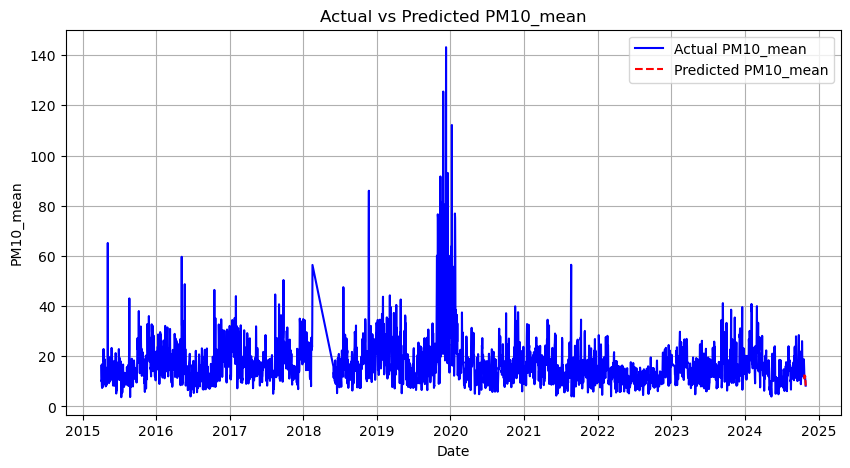

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline


# Define the parameter you want to visualize (e.g., 'CO_mean')
parameter = 'PM10_mean'

# Assuming 'predicted_values_df' contains the predicted values in a DataFrame, with the same index as 'combined_data'
# Plot the actual values over time
plt.figure(figsize=(10, 5))
plt.plot(combined_data.index, combined_data[parameter], label=f'Actual {parameter}', color='b')

# Plot the predicted values over time (in a different color)
plt.plot(predicted_values_df.index, predicted_values_df[parameter], label=f'Predicted {parameter}', color='r', linestyle='--')

# Add titles and labels
plt.title(f'Actual vs Predicted {parameter}')
plt.xlabel('Date')
plt.ylabel(parameter)
plt.legend()
plt.grid(True)
plt.show()



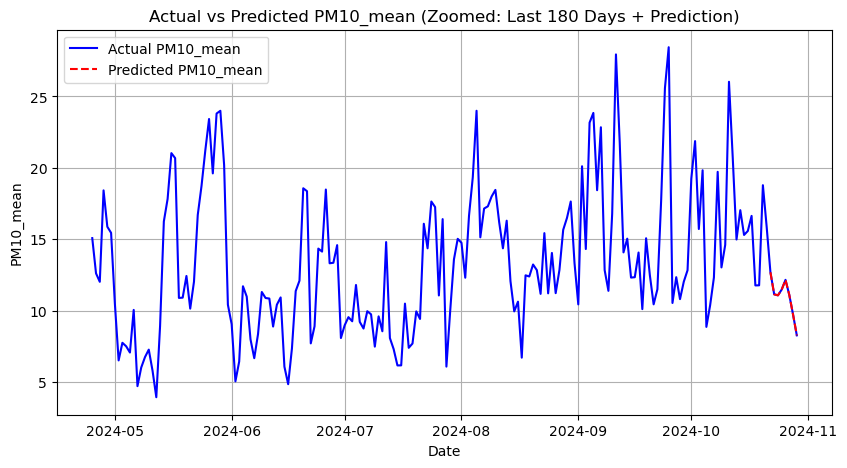

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

# Define the parameter you want to visualize (e.g., 'PM10_mean')
parameter = 'PM10_mean'

# Define the start and end dates for zooming in (last 180 days before the first predicted date)
zoom_start_date = predicted_values_df.index[0] - pd.Timedelta(days=180)
zoom_end_date = predicted_values_df.index[-1]  # Include the prediction period

# Filter the actual values for the 180 days before the prediction
actual_zoomed = combined_data.loc[zoom_start_date:zoom_end_date]

# Plot the actual values over the zoomed-in time period
plt.figure(figsize=(10, 5))
plt.plot(actual_zoomed.index, actual_zoomed[parameter], label=f'Actual {parameter}', color='b')

# Plot the predicted values over the same time period
plt.plot(predicted_values_df.index, predicted_values_df[parameter], label=f'Predicted {parameter}', color='r', linestyle='--')

# Add titles and labels
plt.title(f'Actual vs Predicted {parameter} (Zoomed: Last 180 Days + Prediction)')
plt.xlabel('Date')
plt.ylabel(parameter)
plt.legend()
plt.grid(True)
plt.show()


In [36]:
combined_data.loc['2024-10-21']

CO_mean               0.204301
HUMID_mean           64.559833
NEPH_mean             0.134583
NO_mean              -0.024596
NO2_mean              0.125475
OZONE_mean            2.594704
SO2_mean              0.004076
PM10_mean            15.873292
PM2.5_mean            3.896208
RAIN_sum                   0.0
TEMP_min                15.838
TEMP_max                19.424
WSP_max                  5.481
SD1_mean             22.588208
WDR_mean            190.263208
heavy_vehicle       860.453613
light_vehicle     14591.889648
public_holiday             0.0
school_holiday             0.0
forecast                   NaN
Name: 2024-10-21 00:00:00, dtype: object

# Categorise results

In [96]:
import pandas as pd

# Function to categorize based on the pollutant dictionary
def categorize_value(value, pollutant):
    for category, (low, high) in pollutant_categories[pollutant].items():
        if low <= value < high:
            return category
    return None

# Example pollutant_categories dictionary
pollutant_categories = {
    'CO': {'Good': (0, 1), 'Fair': (1, 2), 'Poor': (2, 5), 'Very Poor': (5, float('inf'))},
    'SO2': {'Good': (0, 13.3), 'Fair': (13.4, 20), 'Poor': (20.1, 30), 'Very Poor': (30.1, float('inf'))},
    'OZONE': {'Good': (0, 5.4), 'Fair': (5.5, 8), 'Poor': (8.1, 12), 'Very Poor': (12.1, float('inf'))},
    'PM10': {'Good': (0, 50), 'Fair': (50, 100), 'Poor': (100, 150), 'Very Poor': (150, float('inf'))},
    'PM2.5': {'Good': (0, 25), 'Fair': (25, 50), 'Poor': (50, 75), 'Very Poor': (75, float('inf'))},
}

# Example pollutant_mapping dictionary
pollutant_mapping = {
    'CO_mean': 'CO',
    'SO2_mean': 'SO2',
    'OZONE_mean': 'OZONE',
    'PM10_mean': 'PM10',
    'PM2.5_mean': 'PM2.5',
}

pollutants = ['CO_mean', 'OZONE_mean', 'PM10_mean', 'PM2.5_mean', 'SO2_mean']


# Assuming your DataFrame contains the columns 'CO_mean', 'OZONE_mean', etc.
for pollutant in pollutants:
    pollutant_key = pollutant_mapping[pollutant]  # Use the correct pollutant name in the dictionary
    combined_data[f'{pollutant_key}'] = combined_data[pollutant].apply(lambda x: categorize_value(x, pollutant_key))

# Function to find the worst category for each row
def worst_category(row):
    categories = row[[f'{pollutant_mapping[pollutant]}' for pollutant in pollutants]]
    category_order = ['Very Poor', 'Poor', 'Fair', 'Good']
    for cat in category_order:
        if cat in categories.values:
            return cat
    return 'Good'

# Get today's date
today = pd.Timestamp.today().normalize()  # Normalize to get just the date (no time component)

# Filter the DataFrame for today and the next 6 days (including today)
next_7_days = combined_data[(combined_data.index >= today) & (combined_data.index < today + pd.Timedelta(days=7))].copy()

# Apply the categorization for the next 7 days and create the 'overall' column
next_7_days['Overall'] = next_7_days.apply(worst_category, axis=1)

# Check if the 'overall' column exists, if not, create it in combined_data
if 'Overall' not in combined_data.columns:
    combined_data['Overall'] = None

# Merge the next 7 days back into the original DataFrame (including the 'overall' column)
combined_data.update(next_7_days)

# Ensure the new 'overall' column is properly added and displayed in the DataFrame
combined_data.loc[next_7_days.index, 'Overall'] = next_7_days['Overall']



# For streamlit

['CO_mean', 'OZONE_mean', 'PM10_mean', 'PM2.5_mean', 'SO2_mean']

In [97]:
today = pd.Timestamp.today().normalize()

next_7_days = today + pd.Timedelta(days=6)

week_data = combined_data.loc[(combined_data.index >= today) & (combined_data.index <= next_7_days)]


In [99]:
week_data.head()

,CO_mean,HUMID_mean,NEPH_mean,NO_mean,NO2_mean,OZONE_mean,SO2_mean,PM10_mean,PM2.5_mean,RAIN_sum,...,public_holiday,school_holiday,forecast,CO,OZONE,PM10,PM2.5,SO2,overall,Overall
2024-10-23,0.187882,64.559833,0.134583,0.547301,0.668562,1.514649,0.049858,11.142067,3.073559,0.0,...,0.0,0.0,Mostly sunny morning. The chance of fog in the...,Good,Good,Good,Good,Good,Good,Good
2024-10-24,0.208911,64.559833,0.134583,0.815310,0.874443,1.370425,0.066353,11.072093,3.793838,9.0,...,0.0,0.0,"Partly cloudy. High chance of showers, most li...",Good,Good,Good,Good,Good,Good,Good
2024-10-25,0.225088,64.559833,0.134583,1.000517,1.017205,1.252399,0.080411,11.480001,4.449006,2.0,...,0.0,0.0,Partly cloudy. Medium chance of showers. Winds...,Good,Good,Good,Good,Good,Good,Good
2024-10-26,0.242674,64.559833,0.134583,1.047098,1.117258,1.296528,0.091702,12.157179,5.388426,1.0,...,0.0,0.0,Partly cloudy. Slight chance of a shower in th...,Good,Good,Good,Good,Good,Good,Good
2024-10-27,0.240510,64.559833,0.134583,0.994688,1.124879,1.421491,0.090879,11.108928,5.796731,1.0,...,0.0,0.0,"Partly cloudy. Slight chance of a shower, most...",Good,Good,Good,Good,Good,Good,Good


In [98]:
graph_week[['CO','SO2','OZONE','PM10','PM2.5']]= week_data[['CO_mean','SO2_mean','OZONE_mean','PM10_mean','PM2.5_mean']]
graph_week.head()

/var/folders/br/kn0p5yrn6d771z_m2v7qll780000gp/T/ipykernel_73596/3332358670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_week[['CO','SO2','OZONE','PM10','PM2.5']]= week_data[['CO_mean','SO2_mean','OZONE_mean','PM10_mean','PM2.5_mean']]


,CO_mean,SO2_mean,OZONE_mean,PM10_mean,PM2.5_mean,CO,SO2,OZONE,PM10,PM2.5
2024-10-23,0.187882,0.049858,1.514649,11.142067,3.073559,0.187882,0.049858,1.514649,11.142067,3.073559
2024-10-24,0.208911,0.066353,1.370425,11.072093,3.793838,0.208911,0.066353,1.370425,11.072093,3.793838
2024-10-25,0.225088,0.080411,1.252399,11.480001,4.449006,0.225088,0.080411,1.252399,11.480001,4.449006
2024-10-26,0.242674,0.091702,1.296528,12.157179,5.388426,0.242674,0.091702,1.296528,12.157179,5.388426
2024-10-27,0.240510,0.090879,1.421491,11.108928,5.796731,0.240510,0.090879,1.421491,11.108928,5.796731


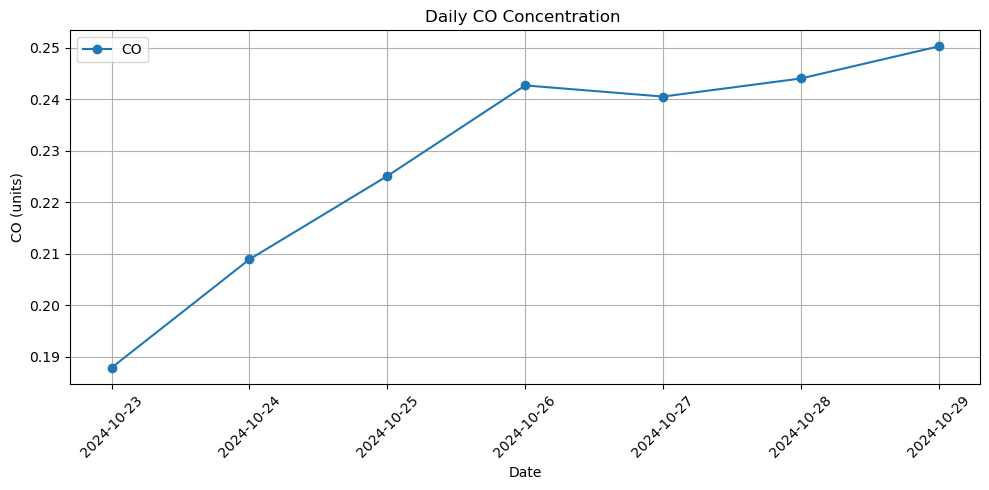

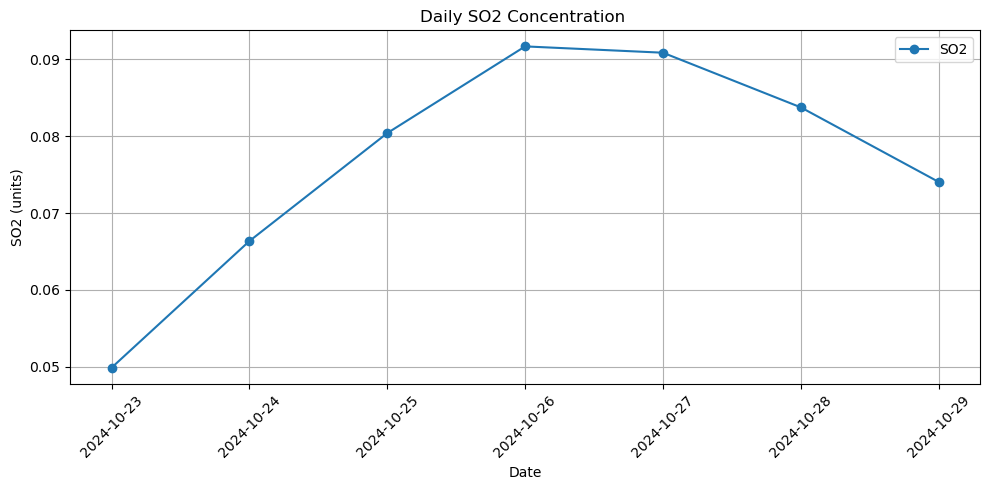

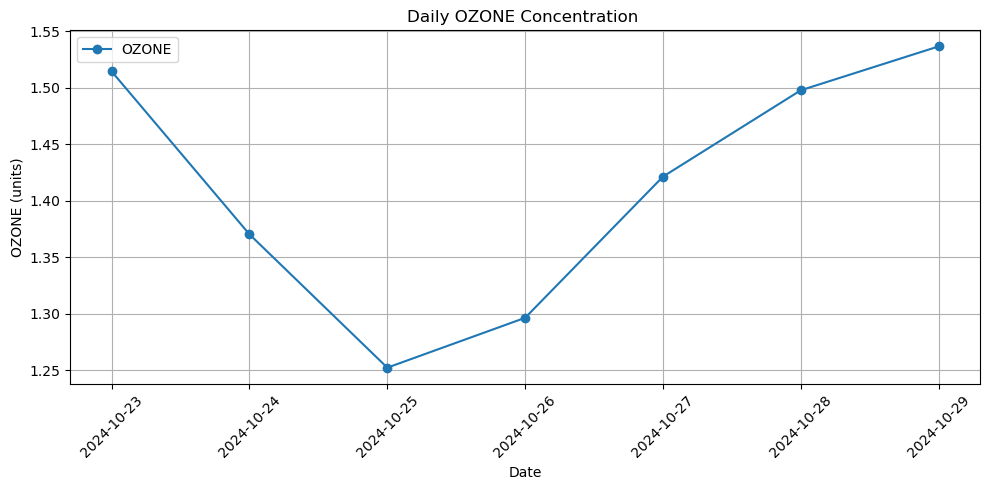

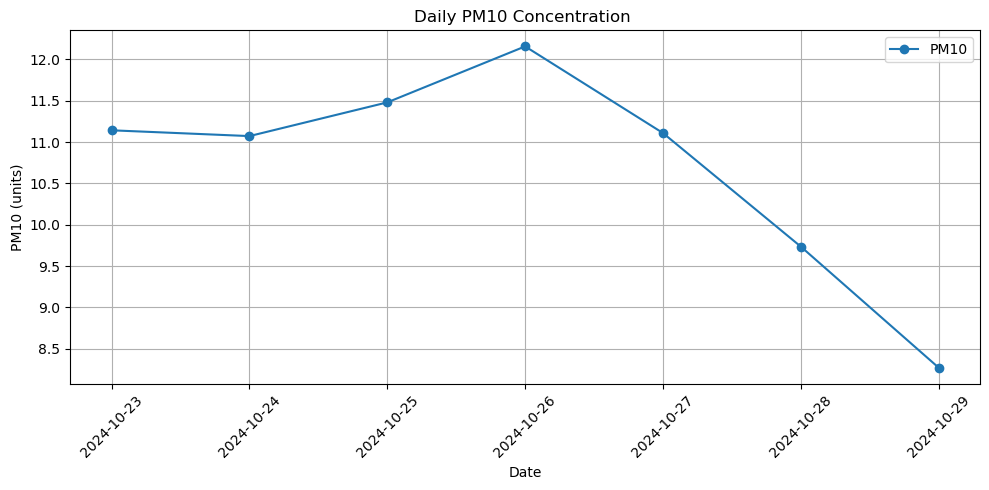

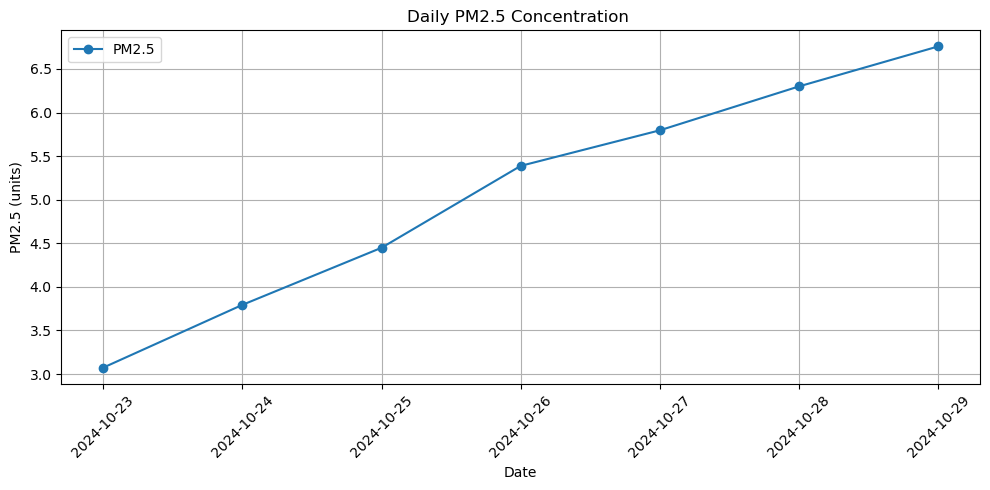

In [102]:
graph_week[['CO','SO2','OZONE','PM10','PM2.5']]= week_data[['CO_mean','SO2_mean','OZONE_mean','PM10_mean','PM2.5_mean']]
graph_week.head()

pollutants = ['CO', 'SO2', 'OZONE', 'PM10', 'PM2.5']
 
for pollutant in pollutants:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot the pollutant values against the index (date)
    ax.plot(graph_week.index, graph_week[pollutant], label=pollutant, marker='o')
    
    ax.set_title(f'Daily {pollutant} Concentration ')
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{pollutant}')
    ax.legend()
    ax.grid(True)
    
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.tight_layout()       # Adjust layout for better spacing
    
    st.pyplot(fig)

In [79]:
# Streamlit app: Sydney Air Quality Forecast
st.title("Sydney Air Quality Forecast")
st.subheader("Weather")

# Show Weather Data (TEMP_min, TEMP_max, RAIN_sum, forecast)
weather_columns = ['TEMP_min', 'TEMP_max', 'RAIN_sum', 'forecast']
st.write(week_data[weather_columns])

# Air Quality Subtitle
st.subheader("Air Quality")

# Function for color coding air quality
def color_air_quality(val):
    color = ''
    if val == 'Good':
        color = 'background-color: green'
    elif val == 'Fair':
        color = 'background-color: yellow'
    elif val == 'Poor':
        color = 'background-color: orange'
    elif val == 'Very Poor':
        color = 'background-color: red'
    return color

# Select the air quality columns to display
air_quality_columns = ['CO','SO2', 'OZONE', 'PM10', 'PM2.5', 'Overall']

# Apply the color formatting
styled_df = week_data[air_quality_columns].style.applymap(color_air_quality)

# Display the styled DataFrame in Streamlit
st.write(styled_df)


2024-10-23 21:26:26.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 21:26:26.225 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 21:26:26.235 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 21:26:26.237 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 21:26:26.348 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 21:26:26.348 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 21:26:26.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 21:26:26.350 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [89]:
pollutant_mapping = {
    'CO_mean': 'CO',
    'SO2_mean': 'SO2',
    'OZONE_mean': 'OZONE',
    'PM10_mean': 'PM10',
    'PM2.5_mean': 'PM2.5',
}
# Rename the columns based on the pollutant_mapping
week_data.rename(columns=pollutant_mapping, inplace=True)

# Create a list of pollutants for graph plotting
pollutants = ['CO', 'SO2', 'OZONE', 'PM10', 'PM2.5']



/var/folders/br/kn0p5yrn6d771z_m2v7qll780000gp/T/ipykernel_73596/769009064.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_data.rename(columns=pollutant_mapping, inplace=True)


In [109]:
graph_week = week_data[['CO_mean','SO2_mean','OZONE_mean','PM10_mean','PM2.5_mean']].copy()

# Rename the columns as per your requirements
pollutants = ['CO', 'SO2', 'OZONE', 'PM10', 'PM2.5']

# Display the head of the new DataFrame to ensure it's working
graph_week.head()

fig, ax = plt.subplots(figsize=(10, 6))

for column in graph_week.columns:
    ax.plot(graph_week.index, graph_week[column], label=column)

# Add labels, title, and legend to the plot
    ax.set_xlabel('Date')
    ax.set_ylabel('Concentration')
    ax.set_title(f'Daily {pollutant} Concentration ')
    ax.legend()
plt.show(fig)

In [110]:
week_data.head()

,CO_mean,HUMID_mean,NEPH_mean,NO_mean,NO2_mean,OZONE_mean,SO2_mean,PM10_mean,PM2.5_mean,RAIN_sum,...,public_holiday,school_holiday,forecast,CO,OZONE,PM10,PM2.5,SO2,overall,Overall
2024-10-23,0.187882,64.559833,0.134583,0.547301,0.668562,1.514649,0.049858,11.142067,3.073559,0.0,...,0.0,0.0,Mostly sunny morning. The chance of fog in the...,Good,Good,Good,Good,Good,Good,Good
2024-10-24,0.208911,64.559833,0.134583,0.815310,0.874443,1.370425,0.066353,11.072093,3.793838,9.0,...,0.0,0.0,"Partly cloudy. High chance of showers, most li...",Good,Good,Good,Good,Good,Good,Good
2024-10-25,0.225088,64.559833,0.134583,1.000517,1.017205,1.252399,0.080411,11.480001,4.449006,2.0,...,0.0,0.0,Partly cloudy. Medium chance of showers. Winds...,Good,Good,Good,Good,Good,Good,Good
2024-10-26,0.242674,64.559833,0.134583,1.047098,1.117258,1.296528,0.091702,12.157179,5.388426,1.0,...,0.0,0.0,Partly cloudy. Slight chance of a shower in th...,Good,Good,Good,Good,Good,Good,Good
2024-10-27,0.240510,64.559833,0.134583,0.994688,1.124879,1.421491,0.090879,11.108928,5.796731,1.0,...,0.0,0.0,"Partly cloudy. Slight chance of a shower, most...",Good,Good,Good,Good,Good,Good,Good
